In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2
using Printf

# include("./readers.jl")
include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
using .read_vecnav: read_vecnav_dict
using .chunks

include("./timing_lidar.jl")
using .timing_lidar

# using MAT

using PyPlot
using PyCall
using PyCall: PyObject

# PyObject method interprets Array{Union{T,Missing}} as a
# numpy masked array.
# This allows for plotting with missing values.
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

  Activating project at `~/Projects/ASTRAL/lidar`


PyObject

In [2]:
# function library with utility functions,  functions for subsetting, for displacements, and for structure functions

# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x
good(x) = !ismissing(x) & isfinite(x)

"bin average y(x) in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"""
Return all the indices i such that each xl[i] is the first >= each xs.
Assumes xs, xl are ordered and loops through xs only once.
Quarry for needles xs in haystack xl.
"""
function findindices(xs, xl)
    # needles xs define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average xl within windows to right of points of the index ind of xl"
function indavg(xl, ind; full=20)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx) : min(length(xl),idx+full)
        # xm[i] = sum(Float64.(xl[ii])) / (full+1)
        xm[i] = mean(Float64.(xl[ii]))
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# functions for indexing sample pairs for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

# functions for displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [3]:
# module chunks for timing and reading functions for contiguous stare chunks
# MOVED to read_lidar.jl

#=
module chunks

export read_stare_time, read_stare_chunk

"""
get_time_shift(mdv, heave) positive result means mdv clock is fast.
sync by subtracting this lag (in 1020 millisecods) from stare_dt.
"""
function get_time_shift(mdv, heave)
    # filter to make xcorr work better
    xc = xcorr(hp(mdv[:]), hp(heave[:]))
    # plot(-(length(mdv)-1):length(mdv)-1, xc )
    return argmax(xc) - length(mdv)
end

"return indices of contiguous chunks (separated by < thr) from a series of datetimes"
function dt_to_chunkind(dt, thr=Second(30))
    pickets = findall( t -> t>thr, diff(dt) )
    st_chunk = pickets[1:end-1] .+ 1
    en_chunk = pickets[2:end]
    return st_chunk, en_chunk
end

"hourly files -> chunk time indices"
function read_stare_time( St )
    # Lidar clock is fast (ahead) by 126832 milliseconds compared to the GPS.
    # Moving the timeseries backward (lagging the lidar) compensates its clock error.
    # adjust the lidar clock backward to agee with the GPS clock.
    lidar_clock_fast_by = Millisecond( 126832 ) # first adjustment
    stare_dt = @. (
        DateTime(Date(dt)) 
        + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
        .- lidar_clock_fast_by ) # 3202

    # split into individual stare chunks
    # pickets = findall( t -> t>Second(30), diff(stare_dt) )
    # # st = [1; pickets.+1] # ignore start and end of file with a split chunk
    # # en = [pickets; length(stare_dt)]
    # st_chunk = pickets[1:end-1] .+ 1
    # en_chunk = pickets[2:end]
    st_chunk, en_chunk = dt_to_chunkind(stare_dt)
    # subdivide into shorter chunks???
    return st_chunk, en_chunk
end

# "subdivide interval [st en] into fac even intervals"
# subdivide(st,en, fac) = round(Integer, st .+ (st-en)/fac .* [0:fac])
"subdivide single interval [st en] into fac even intervals"
subdivide(st,en, fac) = @. round(Integer, st + ((en-st)*(0:fac)/fac))
# # test
# subdivide(1,240, 4)

"read and interpolate data to stare chunks"
function read_stare_chunk(St, Vn, UV, st, en )
    # time: truncate the file's datestamp to Date, add the decimal hour
    stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202
    lidar_clock_fast_by = Millisecond( 126832 ) # adjust for lidar clock fast (ahead) by 126832 milliseconds compared to the GPS.
    stare_dt = stare_dt_raw .- lidar_clock_fast_by

    # dopplervel (time, z) masked by intensity
    dopplervel = masklowi.(St[:dopplervel][st:en,1:ntop], St[:intensity][st:en,1:ntop])
    mdv = missmean(dopplervel, dims=2)[:] # conditional mean can have biases

    # interpolate Ur,Vr, heave to the lidar stare grid
    ind = findindices( stare_dt[st:en], Vn["time"] )
    pitch = indavg( Vn["pitch"], ind) # 11-point mean
    roll  = indavg( Vn["roll" ], ind)
    heave = indavg( Vn["heave"], ind)
    # resync the clock to the VactorNav heave - brittle
    stare1dt = stare_dt[st:en] # subset
    ind = findindices( stare1dt, Vn["time"] )
    heave = Vn["heave"][ind]
    shift = get_time_shift(mdv[:],heave[:])
    # interpolate for the updated synced time
    stare1dt .-= Millisecond((1020-80)*shift)
    ind = findindices( stare1dt, Vn["time"] ) # this works
    heave = indavg( Vn["heave"], ind)

    # mean relative velocity
    Ur = zeros(size(dopplervel))
    Vr = zeros(size(dopplervel))
    ind = findindices( Dates.value.(stare1dt), Dates.value.(UV["time"]))
    # result must be 1:1 for stare1dt and ind
    ls = length(stare1dt)
    li = length(ind)
    if li < ls # extend ind with last index of UV
        ind = [ind; length(UV["time"]).+zeros(Int32, ls-li)]
    end
    for ih in 1:ntop # loop to broadcast to consistent size
        Ur[:,ih] .= UV[:ur][ind,ih]
        Vr[:,ih] .= UV[:vr][ind,ih]
    end

    # questionable: fill all the mean relative velocities
    isf = isfinite.(Vr)
    Vr[.!isf] .= mean(Vr[isf])
    Ur[.!isf] .= mean(Ur[isf])
    
    return dopplervel, pitch, roll, heave, Ur, Vr, mdv
end

end # module chunks

using .chunks
=#

In [4]:
# functions for subsetting and finding the offset with max covariance
# newer: 2025-02

"""
return indices jl, js to subset windows dtl[jl], dts[js] st. 
limdtl[1]+offset <= dtl[jl] <= limdtl[2]+offset
limdtl[1]        <= dts[js] <= limdtl[2]
offset shifts the window in the long step coordinates
"""
# use with code for chunks found elsewhere
function offset_subset(dtl, dts, limdtl, offset=eltype(limdtl)(0))
    # index the long data set (gappy Halo) with absolute time deltas
    jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
    return jl, js
end

function offset_cov(dtl, dts, limdtl, offset, yl, ys)
    jl, js = offset_subset(dtl, dts, limdtl, offset)
    # try
    #     ii = isfinite.(yl[jl]) .&& isfinite.(ys[js]) # skip NaNs # sometimes breaks: arrays not broadcast to consistent size
    #     yl[jl][ii]
    # catch
    #     print("limdtl=$(limdtl) offset=$(offset) jl($(length(jl))), js($(length(js)))")
    # end
    # return cov = mean( skipmissing(yl[jl][ii] .* ys[js][ii]) ) # skip missings
    nn = @. good(yl[jl]) & good(ys[js])
    a_cov = cov(yl[jl][nn], ys[js][nn])
    # a_cov = mean( skipmissing(anom(yl[jl]) .* anom(ys[js])) ) # skip missings
    return a_cov
end

"find optimal offset timedelta (seconds) that syncs yl, ys"
function offset_range_covs(dtl, dts, limdtl, rangeoffset, yl, ys)
    covs = [ offset_cov(dtl, dts, limdtl, offset, yl, ys) 
                for offset in rangeoffset ]
end

"""
return the time offset that syncs dtl (Halo) and dts (VN) for the 
window limdt=[chunkdtstart, chunkdtend]
"""
function sync_offset(dtl, dts, yl, ys, limdt, rangeoffset=Second(0):Second(1):Second(200))
    rangecovs = offset_range_covs(dtl, dts, limdt, rangeoffset, yl, ys)
    maxcov, fm = findmax(rangecovs)
    bestoffset = rangeoffset[fm]
    return bestoffset, maxcov, std(rangecovs)
end

sync_offset

In [8]:
# example to get indices of start and end of chunks for one day
# tests functions proposed to MOVE to module read_lidar.chunks

# include("read_lidar.jl") # reloads reader modules

# set up this day
thisdt = DateTime(2024,6,3)
dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
datapath = joinpath.(pwd(),"data",dtstamp)
files = filter(startswith("Stare"), readdir(datapath))
fullfiles = joinpath.(datapath, files)
# also read the first hour of the next day
nextdt = thisdt + Day(1)
nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]

# read all times in those files
ta, hdr, nbeams = read_lidar.read_streamlinexr_beam_timeangles(full25files) # 5 s per day
# ta
# times, ibeam1, nbeams, h = read_lidar.read_streamlinexr_beam_times(fullfiles) # 5 s per day DEPRECATED
fi1, filast = get_all_file_start_end_idxs(ta)

hourbeams = hour_beams(ta) # decimal hour of each beam
hourbeams[1:5] * 3600 # show seconds since start of day

# find wrapped indices
i20 = findfirst(ta[:time] .> 20.0)
wrap = (i20-1) .+ findall( ta[:time][i20:end] .< 5 )
tatime = ta[:time]
# increment wrapped times by 24 h
tatime[wrap] .+= 24.0
# plot(tatime); gcf()

# find indices
ien, ist = all_gaps(tatime) # identify indices of chunks from gaps
ii, jj = all_start_end_indices(ien, ist) ## jj is a LinearIndices

# Request some beam times. Low-level query takes indices.
# find indices qst, qen for the request
dt = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # ta[:time] is decimal hour
# time wraps around at 0 UTC
# problem: date not defined in ta
qst = findfirst(dt .>= thisdt + Hour(5))
qen = findlast( dt .<  thisdt + Hour(10))
# # try ones that wrap at 00Z
# qst = findfirst(dt .>= thisdt )
# qen = findlast( dt .<  thisdt + Minute(10)) # 10 min should be enough

# get first and last indices of requested chunks
(ist1,ien1, lastist,lastien) = query_start_end_chunks(qst, qen; ien=ien, ist=ist)
# request start and end of all the chunks between ist1 and lastien
istsub, iensub = all_chunks(ist1, lastien, ii)

# sort the chunks by file

# Subset the data within the file to the reuqested chunks
# could be done by skipping to start_beam, and stopping at stop_beam.
ibeam1 = ta[:ibeam1]
# idx_beams_in_file(i, ibeam1) = i - ibeam1[thisfile_idx(i, fi1, filast)] + 1
# start_beam = idx_beams_in_file(ist1   , ibeam1, fi1, filast) # default = 1
# stop_beam  = idx_beams_in_file(lastien, ibeam1, fi1, filast) # default = ta[:nbeams]
# only ever truncate the data read by a file because of a
# intentional scientific user-level query

# @show ist1, lastien
# @show [fi1 filast]
# let bigstartat=ist1, bigendat=lastien
#     mask = ( filast.>=bigstartat .&& fi1.<=bigendat )
# end


# read the beam data between ist1 and lastien
beams, h, nbeams0 = read_lidar.read_streamlinexr_stare(full25files, fi1, filast, ist1, lastien)
beams[:dopplervel]
# I don't understand why beams time loops around.
Vn = read_vecnav_dict()
ta
istsub, iensub # increasing

([16156, 16694, 17233, 17771, 18310, 18847, 19386, 19924, 20463, 21001  …  26925, 27463, 28002, 28540, 29079, 29617, 30156, 30694, 31233, 31771], [16693, 17232, 17770, 18309, 18846, 19385, 19923, 20462, 21000, 21539  …  27462, 28001, 28539, 29078, 29616, 30155, 30693, 31232, 31770, 32307])

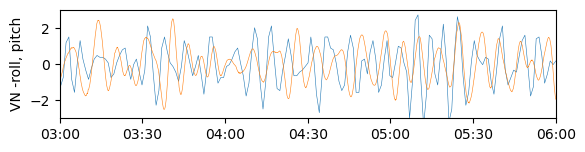

In [11]:
# manual syncing looks like Halo abs(pitch) is ~ abs(VN roll)
# Halo time is +70 s later, VN signals occur at 70 s earlier VN time (6-1)
# Halo time is +120 s later, VN signals occur at 120 s earlier VN time (6-8)
# Shift Halo to agree with VN, which agrees with GPS and POSMV GPS!
thisdt = DateTime(2024,6,3)
lx = [thisdt, thisdt+Minute(3)]
lx = thisdt + Hour(12) .+ Minute.([3, 6])
ii = findall(lx[1] .<= Vn[:vndt] .<= lx[2])

offset = Second(125) # set manually here

clf()
subplot(3,1,1)
# plot(dt-Second(120), anom(ta[:roll]), linewidth=0.4)
plot(dt-offset, anom(ta[:pitch]), linewidth=0.4)
ylabel("Halo roll, pitch")
xlim(lx)
ylim([-3, 3])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%S"))
# subplot(3,1,2)
plot(Vn[:vndt][ii], anom(-Vn[:Roll ][ii]), linewidth=0.4) # VN pitch is ship roll
# plot(Vn[:vndt][ii][1:20:end], Vn[:Pitch][ii][1:20:end], linewidth=0.4) # VN pitch is ship roll
ylabel("VN -roll, pitch")
xlim(lx)
ylim([-3, 3])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
gcf()

Halo time is +70 s later, VN signals occur at 70 s earlier VN time (6-1)

Halo time is +125 s later, VN signals occur at 125 s earlier VN time (6-8)

Shift Halo to agree with VN, which agrees with GPS and POSMV GPS!
`lx = thisdt .+ Hour.([0,2])`

failed: match the envelope first, then match the phase.

Manual syncing using the envelope breaks - overfills the notebook cache

In [ ]:
# procedural test of finding offsets timing offsets 

# define inputs:
thisdt = DateTime(2024,6,3)
limdtl = thisdt + Hour(1) .+ Minute([0,5])
dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # long timesteps
yl = ta[:pitch] # long-step data
dts = Vn[:vndt] # short timesteps
ys = Vn[:Roll]  # short-step data

jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
# comb the time indices out of VN dts
js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
nn = @. good(yl[jl]) & good(ys[js])
# rangecovs[i] = mean( skipmissing(yl[jl] .* ys[js]) )
a_cov = cov(yl[jl][nn], ys[js][nn])

rangecovs = Vector{Float64}(undef, length(rangeoffset))
for (i, offset) in enumerate(rangeoffset)
    jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
    nn = @. good(yl[jl]) & good(ys[js])
    # rangecovs[i] = mean( skipmissing(yl[jl] .* ys[js]) )
    rangecovs[i] = cov(yl[jl][nn], ys[js][nn])
end


In [17]:
# usage recipe
#=
rangeoffset = Second(0):Second(1):Second(200)
# now loop e.g., loop over days
dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # long timesteps
yl = ta[:pitch] # long-step data
dts = Vn[:vndt] # short timesteps
ys = Vn[:Roll]  # short-step data
# set the limit for each chunk in a loop
limdt = [chunkdtstart, chunkdtend]
offset[ichunk] = sync_offset( dtl, dts, yl, ys, limdt, rangeoffset )

# inspect timeangles timing:
ta[:start_time][1] - dtl[1] # close to 1 s
# interpret ta[:start_time] as time the computer starts the file, 
# and dtl[1] is the time of the first 1-s sample logged
=#

Positive offsets make the l window select from forward in the original l timeseries, 
and shift the data in this window backward to compare with an earlier 
(0-offset) time in the s series.
Thus l signals are advanced to earlier times to align with earlier (0 offset).
signals in the s series. 

This disagram depicts the alignment of the windows of the
Halo and VectorNav data windows.
```
                 ---> time
Halo    l   ---|----signals |ere----        Halo time series with |requested window|
            --->>>>[signals here]---   >>>> offset
            ---[signals here]<<<<---   <<<< aligns later l data with s data
            ---[vecnavs gnal]-------        nearest points to nonmissing data in window
VecNav  s   ---|vecnavsignal|-------
```

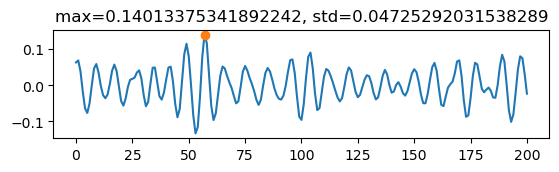

In [ ]:
# example finding optimal offset of Halo to match VN time

thisdt = DateTime(2024,6,8) # must be an integral Date for dtl to work!
# ta[:time] is decimal hour
dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # long timesteps

limdtl = thisdt + Hour(5) .+ Minute.([30,40])
yl = ta[:pitch] # long-step data
dts = Vn[:vndt] # short timesteps
ys = Vn[:Roll]  # short-step data
maxoffset = Second(300)
delta = Second(1)
# test the subsetting

# rangeoffset = -abs(maxoffset):delta:abs(maxoffset)
rangeoffset = -Second(0):Second(1):Second(200)

# rangeoffset = Second(-124)-Second(300):delta:Second(-124)+Second(300)

# pre-subset windows ± offsets
il = findall(limdtl[1]-3*maxoffset .<= dtl .<= limdtl[2]+3*maxoffset)
is = findall(limdtl[1]-3*maxoffset .<= dts .<= limdtl[2]+3*maxoffset)

# indices for the window; unshifted w/ offset=0 seconds
jl, js = offset_subset(dtl[il], dts[is], limdtl, Second(0))
# test
# [dtl[il][jl[1]], dts[is][js[1]]]

# scan covs for a range of offsets
rangecovs = offset_range_covs(dtl[il], dts[is], limdtl, rangeoffset, yl[il], ys[is])
maxcov, fm = findmax(rangecovs)
offset_ = rangeoffset[fm]
offset, maxcov, stdcov = sync_offset( dtl[il], dts[is], yl[il], ys[is], limdtl, rangeoffset )
offset == offset_ # true!

# # procedural 1 offset for debugging
# offset = Second(77)
# jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
# # comb the time indices out of VN dts
# js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
# cov = mean( skipmissing(yl[jl] .* ys[js]) )

good(x) = !ismissing(x) & isfinite(x)

rangecovs = Vector{Float64}(undef, length(rangeoffset))
for (i, offset) in enumerate(rangeoffset)
    jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
    nn = @. good(yl[jl]) & good(ys[js])
    # rangecovs[i] = mean( skipmissing(yl[jl] .* ys[js]) )
    rangecovs[i] = cov(yl[jl][nn], ys[js][nn])
end
maxcov, imax = findmax(rangecovs)

# clf()
# subplot(3,1,2)
# plot(Dates.value.(rangeoffset), rangecovs)
# plot(Dates.value.(rangeoffset[imax]), maxcov, marker="o")
# title("max=$(maxcov), std=$(std(rangecovs))")
# gcf()

# Positive offsets make the l window select from forward in the original l timeseries, 
# and shift the data in this window backward to compare with an earlier 
# (0-offset) time in the s series.
# Thus l signals are advanced to earlier times to align with earlier (0 offset).
# signals in the s series.

# now shift the Halo window by the offset s
jlo, jso = offset_subset(dtl[il], dts[is], limdtl, offset)

# plot the window and shifted window
clf()
subplot(3,1,1)
plot(dtl[jl], yl[jl], linewidth=0.5)
plot(dtl[jlo], ys[jso], linewidth=0.5)
# plot(dtl[il][jl], ys[is][js], linewidth=0.5)
# plot(dtl[il][jlo], ys[is][jso], linewidth=0.5)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
xlim(limdtl)
title(Dates.format(limdtl[1], dateformat"yyyy-mm-dd HH:MM"))
subplot(3,1,2)
plot(dtl[jlo], yl[jlo], linewidth=0.5)
# plot(dts[is][jso], ys[is][jso], linewidth=0.5)
plot(dtl[il][jlo], ys[is][jso], linewidth=0.5)
xlim(limdtl)
xlim(limdtl[1] .+ Minute.([1,5]))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
title("offset = $(offset)")
subplot(3,1,3)
plot(Dates.value.(rangeoffset), rangecovs)
plot(Dates.value(offset), maximum(rangecovs), marker=".")

tight_layout()
gcf()

# time offsets are 125 s around 2024-6-8
# time offset = 100 ± 30 s or so??

In [ ]:

# Positive offsets make the l window select from forward in the original l timeseries, 
# and shift the data in this window backward to compare with an earlier 
# (0-offset) time in the s series.
# Thus l signals are advanced to earlier times to align with earlier (0 offset).
# signals in the s series.

# now shift the Halo window by the offset s
jlo, jso = offset_subset(dtl[il], dts[is], limdtl, offset)

# plot the window and shifted window
clf()
subplot(3,1,1)
plot(dtl[jl], yl[jl], linewidth=0.5)
plot(dtl[jlo], ys[jso], linewidth=0.5)
# plot(dtl[il][jl], ys[is][js], linewidth=0.5)
# plot(dtl[il][jlo], ys[is][jso], linewidth=0.5)
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
xlim(limdtl)
title(Dates.format(limdtl[1], dateformat"yyyy-mm-dd HH:MM"))
subplot(3,1,2)
plot(dtl[jlo], yl[jlo], linewidth=0.5)
# plot(dts[is][jso], ys[is][jso], linewidth=0.5)
plot(dtl[il][jlo], ys[is][jso], linewidth=0.5)
xlim(limdtl)
xlim(limdtl[1] .+ Minute.([1,5]))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
title("offset = $(offset)")
subplot(3,1,3)
plot(Dates.value.(rangeoffset), rangecovs)
plot(Dates.value(offset), maximum(rangecovs), marker=".")

tight_layout()
gcf()

# time offsets are 125 s around 2024-6-8
# time offset = 100 ± 30 s or so??

In [109]:
# deprecated - plot some envelope stuff
#=
xs=Vn[:vndt]
ii = findall(lx[1]-Minute(2) .<= xs .<= lx[2])

clf()
subplot(3,1,1)
# plot(dt-Second(120), anom(ta[:roll]), linewidth=0.4)
plot(dt, anom(ta[:pitch]), linewidth=0.4)
plot(dt,  envh, linewidth=0.4)
ylabel("Halo roll, pitch")
xlim(lx)
ylim([-3, 3])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%S"))
# subplot(3,1,2)
plot(Vn[:vndt][ii], anom(-Vn[:Roll ][ii.-10*optlag]), linewidth=0.4) # VN pitch is ship roll
plot(Vn[:vndt][ii], envv[ii.-optlag], linewidth=0.4) # VN pitch is ship roll
# plot(Vn[:vndt][ii][1:20:end], Vn[:Pitch][ii][1:20:end], linewidth=0.4) # VN pitch is ship roll
ylabel("VN -roll, pitch")
xlim(lx)
ylim([-3, 3])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%M:%S"))
gcf()
=#

The chunks do not end exactly at hourly files, or even at the turnover 
of the day. A way to deal with this is 
 - Read `timeangles` in daily batches. 
 - The queried data starts at 00 of the day, and ends at the end of the day,
   or 00:00:00 of day+1.
 - Daily batches additionally include the following 00 hour of the next day 
   - This will provide for reading the
   end of the last chunk that runs into the next day.
 - Read only queried data; there will be minimal overlap for reading 
   some of the last chunk in the 00 h day+1 file.

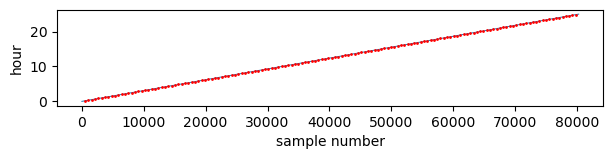

In [110]:
# test identifying stare starts from a day of data
length(ta[:time]) #  80_000, number of seconds in daily files.
ta[:start_time] # hourly start times
# plot(ta[:elevangle],marker=".", linestyle="none") # all stares ~90 degree elev
starestart = findall(diff(ta[:time]).>(20/3600)) .+ 1 # 150 stares per day

clf()
subplot(3,1,1)
plot(ta[:time], linewidth=0.7) # hour offsets from day
plot(starestart, ta[:time][starestart], marker=".", markersize=2, color="r", linestyle="none") # hour offsets from day
ylabel("hour")
xlabel("sample number")
# xlim([0, 7200])
# ylim([0, 2])
# xlim([64000, lastien+60])
# ylim([20, 25])
gcf()

## Find offset between VN and Halo lidar

In [111]:
Vn = read_vecnav_dict() # read all VN data
dts = Vn[:vndt] # short timesteps
ys  = Vn[:Roll]  # short-step data

rangeoffset = -Second(0):Second(1):Second(200)

ichunk = 0
offset = zeros(Second, 150)
thisdt = DateTime(2024,6,2) # loop over days, compile timeangles daily
    dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
    print( "$(Dates.format(thisdt, dateformat"mmdd"))," )
    datapath = joinpath.(pwd(),"data",dtstamp)
    files = filter(startswith("Stare"), readdir(datapath))
    fullfiles = joinpath.(datapath, files)
    # also read the first hour of the next day
    nextdt = thisdt + Day(1)
    nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
    if day(thisdt) < 13
        hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
        full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]
    else
        full25files = fullfiles
    end
    
    # read all times in those files
    ta, _, _ = read_lidar.read_streamlinexr_beam_timeangles(full25files) # 5 s per day
    
    # lidar time axis
    tatime = ta[:time] # hours
    i20 = findfirst(tatime .> 20.0)
    wrap = (i20-1) .+ findall( tatime[i20:end] .< 5 )
    tatime[wrap] .+= 24.0 # increment wrapped times from next day by 24 h
    # 1 Hz lidar datetime for 1 full day
    dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # lidar timesteps
    yl = ta[:pitch] # long-step lidar pitch data
    # length(dtl), length(yl), length(dts), length(ys)

    # identify stare chunks from time gaps
    st_chunk, en_chunk = dt_to_chunkind( dtl ) # ~150 stares per day, Halo lidar indices
    # loop over chunks # ichunk = 0
    ic = 1
    # for ic in eachindex(st_chunk)
        ichunk += 1
        limdt = [dtl[st_chunk[ic]], dtl[en_chunk[ic]]]
        print("$(limdt)\n")
        # pre-subset windows ± offsets
        il = findall(limdt[1]-Second(100) .<= dtl .<= limdt[2]+Second(200))
        is = findall(limdt[1]-Second(100) .<= dts .<= limdt[2]+Second(200))
        offset[ichunk] = sync_offset( dtl[il], dts[is], yl[il], ys[is], limdt, rangeoffset )
    # end

# tests
#=
rangecovs = offset_range_covs(dtl[il], dts[is], limdt, rangeoffset, yl[il], ys[is])
_, fm = findmax(rangecovs)
offset_ = rangeoffset[fm]

clf(); 
subplot(3,1,1)
plot(Dates.value.(rangeoffset), rangecovs)
title("offset=$(offset_) $(offset)")
gcf()
=#

0602,[DateTime("2024-06-02T00:08:16.240"), DateTime("2024-06-02T00:17:26.100")]


BoundsError: BoundsError: attempt to access 539-element Vector{Union{Missing, Float32}} at index [[30048627, 30048628, 30048629, 30048630, 30048631, 30048632, 30048633, 30048634, 30048635, 30048636, 30048637, 30048638, 30048639, 30048640, 30048641, 30048642, 30048643, 30048644, 30048645, 30048646, 30048647, 30048648, 30048649, 30048650, 30048651, 30048652, 30048653, 30048654, 30048655, 30048656, 30048657, 30048658, 30048659, 30048660, 30048661, 30048662, 30048663, 30048664, 30048665, 30048666, 30048667, 30048668, 30048669, 30048670, 30048671, 30048672, 30048673, 30048674, 30048675, 30048676, 30048677, 30048678, 30048679, 30048680, 30048681, 30048682, 30048683, 30048684, 30048685, 30048686, 30048687, 30048688, 30048689, 30048690, 30048691, 30048692, 30048693, 30048694, 30048695, 30048696, 30048697, 30048698, 30048699, 30048700, 30048701, 30048702, 30048703, 30048704, 30048705, 30048706, 30048707, 30048708, 30048709, 30048710, 30048711, 30048712, 30048713, 30048714, 30048715, 30048716, 30048717, 30048718, 30048719, 30048720, 30048721, 30048722, 30048723, 30048724, 30048725, 30048726, 30048727, 30048728, 30048729, 30048730, 30048731, 30048732, 30048733, 30048734, 30048735, 30048736, 30048737, 30048738, 30048739, 30048740, 30048741, 30048742, 30048743, 30048744, 30048745, 30048746, 30048747, 30048748, 30048749, 30048750, 30048751, 30048752, 30048753, 30048754, 30048755, 30048756, 30048757, 30048758, 30048759, 30048760, 30048761, 30048762, 30048763, 30048764, 30048765, 30048766, 30048767, 30048768, 30048769, 30048770, 30048771, 30048772, 30048773, 30048774, 30048775, 30048776, 30048777, 30048778, 30048779, 30048780, 30048781, 30048782, 30048783, 30048784, 30048785, 30048786, 30048787, 30048788, 30048789, 30048790, 30048791, 30048792, 30048793, 30048794, 30048795, 30048796, 30048797, 30048798, 30048799, 30048800, 30048801, 30048802, 30048803, 30048804, 30048805, 30048806, 30048807, 30048808, 30048809, 30048810, 30048811, 30048812, 30048813, 30048814, 30048815, 30048816, 30048817, 30048818, 30048819, 30048820, 30048821, 30048822, 30048823, 30048824, 30048825, 30048826, 30048827, 30048828, 30048829, 30048830, 30048831, 30048832, 30048833, 30048834, 30048835, 30048836, 30048837, 30048838, 30048839, 30048840, 30048841, 30048842, 30048843, 30048844, 30048845, 30048846, 30048847, 30048848, 30048849, 30048850, 30048851, 30048852, 30048853, 30048854, 30048855, 30048856, 30048857, 30048858, 30048859, 30048860, 30048861, 30048862, 30048863, 30048864, 30048865, 30048866, 30048867, 30048868, 30048869, 30048870, 30048871, 30048872, 30048873, 30048874, 30048875, 30048876, 30048877, 30048878, 30048879, 30048880, 30048881, 30048882, 30048883, 30048884, 30048885, 30048886, 30048887, 30048888, 30048889, 30048890, 30048891, 30048892, 30048893, 30048894, 30048895, 30048896, 30048897, 30048898, 30048899, 30048900, 30048901, 30048902, 30048903, 30048904, 30048905, 30048906, 30048907, 30048908, 30048909, 30048910, 30048911, 30048912, 30048913, 30048914, 30048915, 30048916, 30048917, 30048918, 30048919, 30048920, 30048921, 30048922, 30048923, 30048924, 30048925, 30048926, 30048927, 30048928, 30048929, 30048930, 30048931, 30048932, 30048933, 30048934, 30048935, 30048936, 30048937, 30048938, 30048939, 30048940, 30048941, 30048942, 30048943, 30048944, 30048945, 30048946, 30048947, 30048948, 30048949, 30048950, 30048951, 30048952, 30048953, 30048954, 30048955, 30048956, 30048957, 30048958, 30048959, 30048960, 30048961, 30048962, 30048963, 30048964, 30048965, 30048966, 30048967, 30048968, 30048969, 30048970, 30048971, 30048972, 30048973, 30048974, 30048975, 30048976, 30048977, 30048978, 30048979, 30048980, 30048981, 30048982, 30048983, 30048984, 30048985, 30048986, 30048987, 30048988, 30048989, 30048990, 30048991, 30048992, 30048993, 30048994, 30048995, 30048996, 30048997, 30048998, 30048999, 30049000, 30049001, 30049002, 30049003, 30049004, 30049005, 30049006, 30049007, 30049008, 30049009, 30049010, 30049011, 30049012, 30049013, 30049014, 30049015, 30049016, 30049017, 30049018, 30049019, 30049020, 30049021, 30049022, 30049023, 30049024, 30049025, 30049026, 30049027, 30049028, 30049029, 30049030, 30049031, 30049032, 30049033, 30049034, 30049035, 30049036, 30049037, 30049038, 30049039, 30049040, 30049041, 30049042, 30049043, 30049044, 30049045, 30049046, 30049047, 30049048, 30049049, 30049050, 30049051, 30049052, 30049053, 30049054, 30049055, 30049056, 30049057, 30049058, 30049059, 30049060, 30049061, 30049062, 30049063, 30049064, 30049065, 30049066, 30049067, 30049068, 30049069, 30049070, 30049071, 30049072, 30049073, 30049074, 30049075, 30049076, 30049077, 30049078, 30049079, 30049080, 30049081, 30049082, 30049083, 30049084, 30049085, 30049086, 30049087, 30049088, 30049089, 30049090, 30049091, 30049092, 30049093, 30049094, 30049095, 30049096, 30049097, 30049098, 30049099, 30049100, 30049101, 30049102, 30049103, 30049104, 30049105, 30049106, 30049107, 30049108, 30049109, 30049110, 30049111, 30049112, 30049113, 30049114, 30049115, 30049116, 30049117, 30049118, 30049119, 30049120, 30049121, 30049122, 30049123, 30049124, 30049125, 30049126, 30049127, 30049128, 30049129, 30049130, 30049131, 30049132, 30049133, 30049134, 30049135, 30049136, 30049137, 30049138, 30049139, 30049140, 30049141, 30049142, 30049143, 30049144, 30049145, 30049146, 30049147, 30049148, 30049149, 30049150, 30049151, 30049152, 30049153, 30049154, 30049155, 30049156, 30049157, 30049158, 30049159, 30049160, 30049161, 30049162, 30049163, 30049164, 30049165, 30049166, 30049167, 30049168, 30049169, 30049170, 30049171, 30049172, 30049173, 30049174, 30049175, 30049176, 30049177, 30049178, 30049179, 30049180, 30049181, 30049182, 30049183, 30049184, 30049185, 30049186, 30049187, 30049188, 30049189, 30049190, 30049191, 30049192, 30049193, 30049194, 30049195, 30049196, 30049197, 30049198, 30049199, 30049200, 30049201, 30049202, 30049203, 30049204, 30049205, 30049206, 30049207, 30049208, 30049209, 30049210, 30049211, 30049212, 30049213, 30049214, 30049215, 30049216, 30049217, 30049218, 30049219, 30049220, 30049221, 30049222, 30049223, 30049224, 30049225, 30049226, 30049227, 30049228, 30049229, 30049230, 30049231, 30049232, 30049233, 30049234, 30049235, 30049236, 30049237, 30049238, 30049239, 30049240, 30049241, 30049242, 30049243, 30049244, 30049245, 30049246, 30049247, 30049248, 30049249, 30049250, 30049251, 30049252, 30049253, 30049254, 30049255, 30049256, 30049257, 30049258, 30049259, 30049260, 30049261, 30049262, 30049263, 30049264, 30049265, 30049266, 30049267, 30049268, 30049269, 30049270, 30049271, 30049272, 30049273, 30049274, 30049275, 30049276, 30049277, 30049278, 30049279, 30049280, 30049281, 30049282, 30049283, 30049284, 30049285, 30049286, 30049287, 30049288, 30049289, 30049290, 30049291, 30049292, 30049293, 30049294, 30049295, 30049296, 30049297, 30049298, 30049299, 30049300, 30049301, 30049302, 30049303, 30049304, 30049305, 30049306, 30049307, 30049308, 30049309, 30049310, 30049311, 30049312, 30049313, 30049314, 30049315, 30049316, 30049317, 30049318, 30049319, 30049320, 30049321, 30049322, 30049323, 30049324, 30049325, 30049326, 30049327, 30049328, 30049329, 30049330, 30049331, 30049332, 30049333, 30049334, 30049335, 30049336, 30049337, 30049338, 30049339, 30049340, 30049341, 30049342, 30049343, 30049344, 30049345, 30049346, 30049347, 30049348, 30049349, 30049350, 30049351, 30049352, 30049353, 30049354, 30049355, 30049356, 30049357, 30049358, 30049359, 30049360, 30049361, 30049362, 30049363, 30049364, 30049365, 30049366, 30049367, 30049368, 30049369, 30049370, 30049371, 30049372, 30049373, 30049374, 30049375, 30049376, 30049377, 30049378, 30049379, 30049380, 30049381, 30049382, 30049383, 30049384, 30049385, 30049386, 30049387, 30049388, 30049389, 30049390, 30049391, 30049392, 30049393, 30049394, 30049395, 30049396, 30049397, 30049398, 30049399, 30049400, 30049401, 30049402, 30049403, 30049404, 30049405, 30049406, 30049407, 30049408, 30049409, 30049410, 30049411, 30049412, 30049413, 30049414, 30049415, 30049416, 30049417, 30049418, 30049419, 30049420, 30049421, 30049422, 30049423, 30049424, 30049425, 30049426, 30049427, 30049428, 30049429, 30049430, 30049431, 30049432, 30049433, 30049434, 30049435, 30049436, 30049437, 30049438, 30049439, 30049440, 30049441, 30049442, 30049443, 30049444, 30049445, 30049446, 30049447, 30049448, 30049449, 30049450, 30049451, 30049452, 30049453, 30049454, 30049455, 30049456, 30049457, 30049458, 30049459, 30049460, 30049461, 30049462, 30049463, 30049464, 30049465, 30049466, 30049467, 30049468, 30049469, 30049470, 30049471, 30049472, 30049473, 30049474, 30049475, 30049476, 30049477, 30049478, 30049479, 30049480, 30049481, 30049482, 30049483, 30049484, 30049485, 30049486, 30049487, 30049488, 30049489, 30049490, 30049491, 30049492, 30049493, 30049494, 30049495, 30049496, 30049497, 30049498, 30049499, 30049500, 30049501, 30049502, 30049503, 30049504, 30049505, 30049506, 30049507, 30049508, 30049509, 30049510, 30049511, 30049512, 30049513, 30049514, 30049515, 30049516, 30049517, 30049518, 30049519, 30049520, 30049521, 30049522, 30049523, 30049524, 30049525, 30049526, 30049527, 30049528, 30049529, 30049530, 30049531, 30049532, 30049533, 30049534, 30049535, 30049536, 30049537, 30049538, 30049539, 30049540, 30049541, 30049542, 30049543, 30049544, 30049545, 30049546, 30049547, 30049548, 30049549, 30049550, 30049551, 30049552, 30049553, 30049554, 30049555, 30049556, 30049557, 30049558, 30049559, 30049560, 30049561, 30049562, 30049563, 30049564, 30049565, 30049566, 30049567, 30049568, 30049569, 30049570, 30049571, 30049572, 30049573, 30049574, 30049575, 30049576, 30049577, 30049578, 30049579, 30049580, 30049581, 30049582, 30049583, 30049584, 30049585, 30049586, 30049587, 30049588, 30049589, 30049590, 30049591, 30049592, 30049593, 30049594, 30049595, 30049596, 30049597, 30049598, 30049599, 30049600, 30049601, 30049602, 30049603, 30049604, 30049605, 30049606, 30049607, 30049608, 30049609, 30049610, 30049611, 30049612, 30049613, 30049614, 30049615, 30049616, 30049617, 30049618, 30049619, 30049620, 30049621, 30049622, 30049623, 30049624, 30049625, 30049626, 30049627, 30049628, 30049629, 30049630, 30049631, 30049632, 30049633, 30049634, 30049635, 30049636, 30049637, 30049638, 30049639, 30049640, 30049641, 30049642, 30049643, 30049644, 30049645, 30049646, 30049647, 30049648, 30049649, 30049650, 30049651, 30049652, 30049653, 30049654, 30049655, 30049656, 30049657, 30049658, 30049659, 30049660, 30049661, 30049662, 30049663, 30049664, 30049665, 30049666, 30049667, 30049668, 30049669, 30049670, 30049671, 30049672, 30049673, 30049674, 30049675, 30049676, 30049677, 30049678, 30049679, 30049680, 30049681, 30049682, 30049683, 30049684, 30049685, 30049686, 30049687, 30049688, 30049689, 30049690, 30049691, 30049692, 30049693, 30049694, 30049695, 30049696, 30049697, 30049698, 30049699, 30049700, 30049701, 30049702, 30049703, 30049704, 30049705, 30049706, 30049707, 30049708, 30049709, 30049710, 30049711, 30049712, 30049713, 30049714, 30049715, 30049716, 30049717, 30049718, 30049719, 30049720, 30049721, 30049722, 30049723, 30049724, 30049725, 30049726, 30049727, 30049728, 30049729, 30049730, 30049731, 30049732, 30049733, 30049734, 30049735, 30049736, 30049737, 30049738, 30049739, 30049740, 30049741, 30049742, 30049743, 30049744, 30049745, 30049746, 30049747, 30049748, 30049749, 30049750, 30049751, 30049752, 30049753, 30049754, 30049755, 30049756, 30049757, 30049758, 30049759, 30049760, 30049761, 30049762, 30049763, 30049764, 30049765, 30049766, 30049767, 30049768, 30049769, 30049770, 30049771, 30049772, 30049773, 30049774, 30049775, 30049776, 30049777, 30049778, 30049779, 30049780, 30049781, 30049782, 30049783, 30049784, 30049785, 30049786, 30049787, 30049788, 30049789, 30049790, 30049791, 30049792, 30049793, 30049794, 30049795, 30049796, 30049797, 30049798, 30049799, 30049800, 30049801, 30049802, 30049803, 30049804, 30049805, 30049806, 30049807, 30049808, 30049809, 30049810, 30049811, 30049812, 30049813, 30049814, 30049815, 30049816, 30049817, 30049818, 30049819, 30049820, 30049821, 30049822, 30049823, 30049824, 30049825, 30049826, 30049827, 30049828, 30049829, 30049830, 30049831, 30049832, 30049833, 30049834, 30049835, 30049836, 30049837, 30049838, 30049839, 30049840, 30049841, 30049842, 30049843, 30049844, 30049845, 30049846, 30049847, 30049848, 30049849, 30049850, 30049851, 30049852, 30049853, 30049854, 30049855, 30049856, 30049857, 30049858, 30049859, 30049860, 30049861, 30049862, 30049863, 30049864, 30049865, 30049866, 30049867, 30049868, 30049869, 30049870, 30049871, 30049872, 30049873, 30049874, 30049875, 30049876, 30049877, 30049878, 30049879, 30049880, 30049881, 30049882, 30049883, 30049884, 30049885, 30049886, 30049887, 30049888, 30049889, 30049890, 30049891, 30049892, 30049893, 30049894, 30049895, 30049896, 30049897, 30049898, 30049899, 30049900, 30049901, 30049902, 30049903, 30049904, 30049905, 30049906, 30049907, 30049908, 30049909, 30049910, 30049911, 30049912, 30049913, 30049914, 30049915, 30049916, 30049917, 30049918, 30049919, 30049920, 30049921, 30049922, 30049923, 30049924, 30049925, 30049926, 30049927, 30049928, 30049929, 30049930, 30049931, 30049932, 30049933, 30049934, 30049935, 30049936, 30049937, 30049938, 30049939, 30049940, 30049941, 30049942, 30049943, 30049944, 30049945, 30049946, 30049947, 30049948, 30049949, 30049950, 30049951, 30049952, 30049953, 30049954, 30049955, 30049956, 30049957, 30049958, 30049959, 30049960, 30049961, 30049962, 30049963, 30049964, 30049965, 30049966, 30049967, 30049968, 30049969, 30049970, 30049971, 30049972, 30049973, 30049974, 30049975, 30049976, 30049977, 30049978, 30049979, 30049980, 30049981, 30049982, 30049983, 30049984, 30049985, 30049986, 30049987, 30049988, 30049989, 30049990, 30049991, 30049992, 30049993, 30049994, 30049995, 30049996, 30049997, 30049998, 30049999, 30050000, 30050001, 30050002, 30050003, 30050004, 30050005, 30050006, 30050007, 30050008, 30050009, 30050010, 30050011, 30050012, 30050013, 30050014, 30050015, 30050016, 30050017, 30050018, 30050019, 30050020, 30050021, 30050022, 30050023, 30050024, 30050025, 30050026, 30050027, 30050028, 30050029, 30050030, 30050031, 30050032, 30050033, 30050034, 30050035, 30050036, 30050037, 30050038, 30050039, 30050040, 30050041, 30050042, 30050043, 30050044, 30050045, 30050046, 30050047, 30050048, 30050049, 30050050, 30050051, 30050052, 30050053, 30050054, 30050055, 30050056, 30050057, 30050058, 30050059, 30050060, 30050061, 30050062, 30050063, 30050064, 30050065, 30050066, 30050067, 30050068, 30050069, 30050070, 30050071, 30050072, 30050073, 30050074, 30050075, 30050076, 30050077, 30050078, 30050079, 30050080, 30050081, 30050082, 30050083, 30050084, 30050085, 30050086, 30050087, 30050088, 30050089, 30050090, 30050091, 30050092, 30050093, 30050094, 30050095, 30050096, 30050097, 30050098, 30050099, 30050100, 30050101, 30050102, 30050103, 30050104, 30050105, 30050106, 30050107, 30050108, 30050109, 30050110, 30050111, 30050112, 30050113, 30050114, 30050115, 30050116, 30050117, 30050118, 30050119, 30050120, 30050121, 30050122, 30050123, 30050124, 30050125, 30050126, 30050127, 30050128, 30050129, 30050130, 30050131, 30050132, 30050133, 30050134, 30050135, 30050136, 30050137, 30050138, 30050139, 30050140, 30050141, 30050142, 30050143, 30050144, 30050145, 30050146, 30050147, 30050148, 30050149, 30050150, 30050151, 30050152, 30050153, 30050154, 30050155, 30050156, 30050157, 30050158, 30050159, 30050160, 30050161, 30050162, 30050163, 30050164, 30050165, 30050166, 30050167, 30050168, 30050169, 30050170, 30050171, 30050172, 30050173, 30050174, 30050175, 30050176, 30050177, 30050178, 30050179, 30050180, 30050181, 30050182, 30050183, 30050184, 30050185, 30050186, 30050187, 30050188, 30050189, 30050190, 30050191, 30050192, 30050193, 30050194, 30050195, 30050196, 30050197, 30050198, 30050199, 30050200, 30050201, 30050202, 30050203, 30050204, 30050205, 30050206, 30050207, 30050208, 30050209, 30050210, 30050211, 30050212, 30050213, 30050214, 30050215, 30050216, 30050217, 30050218, 30050219, 30050220, 30050221, 30050222, 30050223, 30050224, 30050225, 30050226, 30050227, 30050228, 30050229, 30050230, 30050231, 30050232, 30050233, 30050234, 30050235, 30050236, 30050237, 30050238, 30050239, 30050240, 30050241, 30050242, 30050243, 30050244, 30050245, 30050246, 30050247, 30050248, 30050249, 30050250, 30050251, 30050252, 30050253, 30050254, 30050255, 30050256, 30050257, 30050258, 30050259, 30050260, 30050261, 30050262, 30050263, 30050264, 30050265, 30050266, 30050267, 30050268, 30050269, 30050270, 30050271, 30050272, 30050273, 30050274, 30050275, 30050276, 30050277, 30050278, 30050279, 30050280, 30050281, 30050282, 30050283, 30050284, 30050285, 30050286, 30050287, 30050288, 30050289, 30050290, 30050291, 30050292, 30050293, 30050294, 30050295, 30050296, 30050297, 30050298, 30050299, 30050300, 30050301, 30050302, 30050303, 30050304, 30050305, 30050306, 30050307, 30050308, 30050309, 30050310, 30050311, 30050312, 30050313, 30050314, 30050315, 30050316, 30050317, 30050318, 30050319, 30050320, 30050321, 30050322, 30050323, 30050324, 30050325, 30050326, 30050327, 30050328, 30050329, 30050330, 30050331, 30050332, 30050333, 30050334, 30050335, 30050336, 30050337, 30050338, 30050339, 30050340, 30050341, 30050342, 30050343, 30050344, 30050345, 30050346, 30050347, 30050348, 30050349, 30050350, 30050351, 30050352, 30050353, 30050354, 30050355, 30050356, 30050357, 30050358, 30050359, 30050360, 30050361, 30050362, 30050363, 30050364, 30050365, 30050366, 30050367, 30050368, 30050369, 30050370, 30050371, 30050372, 30050373, 30050374, 30050375, 30050376, 30050377, 30050378, 30050379, 30050380, 30050381, 30050382, 30050383, 30050384, 30050385, 30050386, 30050387, 30050388, 30050389, 30050390, 30050391, 30050392, 30050393, 30050394, 30050395, 30050396, 30050397, 30050398, 30050399, 30050400, 30050401, 30050402, 30050403, 30050404, 30050405, 30050406, 30050407, 30050408, 30050409, 30050410, 30050411, 30050412, 30050413, 30050414, 30050415, 30050416, 30050417, 30050418, 30050419, 30050420, 30050421, 30050422, 30050423, 30050424, 30050425, 30050426, 30050427, 30050428, 30050429, 30050430, 30050431, 30050432, 30050433, 30050434, 30050435, 30050436, 30050437, 30050438, 30050439, 30050440, 30050441, 30050442, 30050443, 30050444, 30050445, 30050446, 30050447, 30050448, 30050449, 30050450, 30050451, 30050452, 30050453, 30050454, 30050455, 30050456, 30050457, 30050458, 30050459, 30050460, 30050461, 30050462, 30050463, 30050464, 30050465, 30050466, 30050467, 30050468, 30050469, 30050470, 30050471, 30050472, 30050473, 30050474, 30050475, 30050476, 30050477, 30050478, 30050479, 30050480, 30050481, 30050482, 30050483, 30050484, 30050485, 30050486, 30050487, 30050488, 30050489, 30050490, 30050491, 30050492, 30050493, 30050494, 30050495, 30050496, 30050497, 30050498, 30050499, 30050500, 30050501, 30050502, 30050503, 30050504, 30050505, 30050506, 30050507, 30050508, 30050509, 30050510, 30050511, 30050512, 30050513, 30050514, 30050515, 30050516, 30050517, 30050518, 30050519, 30050520, 30050521, 30050522, 30050523, 30050524, 30050525, 30050526, 30050527, 30050528, 30050529, 30050530, 30050531, 30050532, 30050533, 30050534, 30050535, 30050536, 30050537, 30050538, 30050539, 30050540, 30050541, 30050542, 30050543, 30050544, 30050545, 30050546, 30050547, 30050548, 30050549, 30050550, 30050551, 30050552, 30050553, 30050554, 30050555, 30050556, 30050557, 30050558, 30050559, 30050560, 30050561, 30050562, 30050563, 30050564, 30050565, 30050566, 30050567, 30050568, 30050569, 30050570, 30050571, 30050572, 30050573, 30050574, 30050575, 30050576, 30050577, 30050578, 30050579, 30050580, 30050581, 30050582, 30050583, 30050584, 30050585, 30050586, 30050587, 30050588, 30050589, 30050590, 30050591, 30050592, 30050593, 30050594, 30050595, 30050596, 30050597, 30050598, 30050599, 30050600, 30050601, 30050602, 30050603, 30050604, 30050605, 30050606, 30050607, 30050608, 30050609, 30050610, 30050611, 30050612, 30050613, 30050614, 30050615, 30050616, 30050617, 30050618, 30050619, 30050620, 30050621, 30050622, 30050623, 30050624, 30050625, 30050626, 30050627, 30050628, 30050629, 30050630, 30050631, 30050632, 30050633, 30050634, 30050635, 30050636, 30050637, 30050638, 30050639, 30050640, 30050641, 30050642, 30050643, 30050644, 30050645, 30050646, 30050647, 30050648, 30050649, 30050650, 30050651, 30050652, 30050653, 30050654, 30050655, 30050656, 30050657, 30050658, 30050659, 30050660, 30050661, 30050662, 30050663, 30050664, 30050665, 30050666, 30050667, 30050668, 30050669, 30050670, 30050671, 30050672, 30050673, 30050674, 30050675, 30050676, 30050677, 30050678, 30050679, 30050680, 30050681, 30050682, 30050683, 30050684, 30050685, 30050686, 30050687, 30050688, 30050689, 30050690, 30050691, 30050692, 30050693, 30050694, 30050695, 30050696, 30050697, 30050698, 30050699, 30050700, 30050701, 30050702, 30050703, 30050704, 30050705, 30050706, 30050707, 30050708, 30050709, 30050710, 30050711, 30050712, 30050713, 30050714, 30050715, 30050716, 30050717, 30050718, 30050719, 30050720, 30050721, 30050722, 30050723, 30050724, 30050725, 30050726, 30050727, 30050728, 30050729, 30050730, 30050731, 30050732, 30050733, 30050734, 30050735, 30050736, 30050737, 30050738, 30050739, 30050740, 30050741, 30050742, 30050743, 30050744, 30050745, 30050746, 30050747, 30050748, 30050749, 30050750, 30050751, 30050752, 30050753, 30050754, 30050755, 30050756, 30050757, 30050758, 30050759, 30050760, 30050761, 30050762, 30050763, 30050764, 30050765, 30050766, 30050767, 30050768, 30050769, 30050770, 30050771, 30050772, 30050773, 30050774, 30050775, 30050776, 30050777, 30050778, 30050779, 30050780, 30050781, 30050782, 30050783, 30050784, 30050785, 30050786, 30050787, 30050788, 30050789, 30050790, 30050791, 30050792, 30050793, 30050794, 30050795, 30050796, 30050797, 30050798, 30050799, 30050800, 30050801, 30050802, 30050803, 30050804, 30050805, 30050806, 30050807, 30050808, 30050809, 30050810, 30050811, 30050812, 30050813, 30050814, 30050815, 30050816, 30050817, 30050818, 30050819, 30050820, 30050821, 30050822, 30050823, 30050824, 30050825, 30050826, 30050827, 30050828, 30050829, 30050830, 30050831, 30050832, 30050833, 30050834, 30050835, 30050836, 30050837, 30050838, 30050839, 30050840, 30050841, 30050842, 30050843, 30050844, 30050845, 30050846, 30050847, 30050848, 30050849, 30050850, 30050851, 30050852, 30050853, 30050854, 30050855, 30050856, 30050857, 30050858, 30050859, 30050860, 30050861, 30050862, 30050863, 30050864, 30050865, 30050866, 30050867, 30050868, 30050869, 30050870, 30050871, 30050872, 30050873, 30050874, 30050875, 30050876, 30050877, 30050878, 30050879, 30050880, 30050881, 30050882, 30050883, 30050884, 30050885, 30050886, 30050887, 30050888, 30050889, 30050890, 30050891, 30050892, 30050893, 30050894, 30050895, 30050896, 30050897, 30050898, 30050899, 30050900, 30050901, 30050902, 30050903, 30050904, 30050905, 30050906, 30050907, 30050908, 30050909, 30050910, 30050911, 30050912, 30050913, 30050914, 30050915, 30050916, 30050917, 30050918, 30050919, 30050920, 30050921, 30050922, 30050923, 30050924, 30050925, 30050926, 30050927, 30050928, 30050929, 30050930, 30050931, 30050932, 30050933, 30050934, 30050935, 30050936, 30050937, 30050938, 30050939, 30050940, 30050941, 30050942, 30050943, 30050944, 30050945, 30050946, 30050947, 30050948, 30050949, 30050950, 30050951, 30050952, 30050953, 30050954, 30050955, 30050956, 30050957, 30050958, 30050959, 30050960, 30050961, 30050962, 30050963, 30050964, 30050965, 30050966, 30050967, 30050968, 30050969, 30050970, 30050971, 30050972, 30050973, 30050974, 30050975, 30050976, 30050977, 30050978, 30050979, 30050980, 30050981, 30050982, 30050983, 30050984, 30050985, 30050986, 30050987, 30050988, 30050989, 30050990, 30050991, 30050992, 30050993, 30050994, 30050995, 30050996, 30050997, 30050998, 30050999, 30051000, 30051001, 30051002, 30051003, 30051004, 30051005, 30051006, 30051007, 30051008, 30051009, 30051010, 30051011, 30051012, 30051013, 30051014, 30051015, 30051016, 30051017, 30051018, 30051019, 30051020, 30051021, 30051022, 30051023, 30051024, 30051025, 30051026, 30051027, 30051028, 30051029, 30051030, 30051031, 30051032, 30051033, 30051034, 30051035, 30051036, 30051037, 30051038, 30051039, 30051040, 30051041, 30051042, 30051043, 30051044, 30051045, 30051046, 30051047, 30051048, 30051049, 30051050, 30051051, 30051052, 30051053, 30051054, 30051055, 30051056, 30051057, 30051058, 30051059, 30051060, 30051061, 30051062, 30051063, 30051064, 30051065, 30051066, 30051067, 30051068, 30051069, 30051070, 30051071, 30051072, 30051073, 30051074, 30051075, 30051076, 30051077, 30051078, 30051079, 30051080, 30051081, 30051082, 30051083, 30051084, 30051085, 30051086, 30051087, 30051088, 30051089, 30051090, 30051091, 30051092, 30051093, 30051094, 30051095, 30051096, 30051097, 30051098, 30051099, 30051100, 30051101, 30051102, 30051103, 30051104, 30051105, 30051106, 30051107, 30051108, 30051109, 30051110, 30051111, 30051112, 30051113, 30051114, 30051115, 30051116, 30051117, 30051118, 30051119, 30051120, 30051121, 30051122, 30051123, 30051124, 30051125, 30051126, 30051127, 30051128, 30051129, 30051130, 30051131, 30051132, 30051133, 30051134, 30051135, 30051136, 30051137, 30051138, 30051139, 30051140, 30051141, 30051142, 30051143, 30051144, 30051145, 30051146, 30051147, 30051148, 30051149, 30051150, 30051151, 30051152, 30051153, 30051154, 30051155, 30051156, 30051157, 30051158, 30051159, 30051160, 30051161, 30051162, 30051163, 30051164, 30051165, 30051166, 30051167, 30051168, 30051169, 30051170, 30051171, 30051172, 30051173, 30051174, 30051175, 30051176, 30051177, 30051178, 30051179, 30051180, 30051181, 30051182, 30051183, 30051184, 30051185, 30051186, 30051187, 30051188, 30051189, 30051190, 30051191, 30051192, 30051193, 30051194, 30051195, 30051196, 30051197, 30051198, 30051199, 30051200, 30051201, 30051202, 30051203, 30051204, 30051205, 30051206, 30051207, 30051208, 30051209, 30051210, 30051211, 30051212, 30051213, 30051214, 30051215, 30051216, 30051217, 30051218, 30051219, 30051220, 30051221, 30051222, 30051223, 30051224, 30051225, 30051226, 30051227, 30051228, 30051229, 30051230, 30051231, 30051232, 30051233, 30051234, 30051235, 30051236, 30051237, 30051238, 30051239, 30051240, 30051241, 30051242, 30051243, 30051244, 30051245, 30051246, 30051247, 30051248, 30051249, 30051250, 30051251, 30051252, 30051253, 30051254, 30051255, 30051256, 30051257, 30051258, 30051259, 30051260, 30051261, 30051262, 30051263, 30051264, 30051265, 30051266, 30051267, 30051268, 30051269, 30051270, 30051271, 30051272, 30051273, 30051274, 30051275, 30051276, 30051277, 30051278, 30051279, 30051280, 30051281, 30051282, 30051283, 30051284, 30051285, 30051286, 30051287, 30051288, 30051289, 30051290, 30051291, 30051292, 30051293, 30051294, 30051295, 30051296, 30051297, 30051298, 30051299, 30051300, 30051301, 30051302, 30051303, 30051304, 30051305, 30051306, 30051307, 30051308, 30051309, 30051310, 30051311, 30051312, 30051313, 30051314, 30051315, 30051316, 30051317, 30051318, 30051319, 30051320, 30051321, 30051322, 30051323, 30051324, 30051325, 30051326, 30051327, 30051328, 30051329, 30051330, 30051331, 30051332, 30051333, 30051334, 30051335, 30051336, 30051337, 30051338, 30051339, 30051340, 30051341, 30051342, 30051343, 30051344, 30051345, 30051346, 30051347, 30051348, 30051349, 30051350, 30051351, 30051352, 30051353, 30051354, 30051355, 30051356, 30051357, 30051358, 30051359, 30051360, 30051361, 30051362, 30051363, 30051364, 30051365, 30051366, 30051367, 30051368, 30051369, 30051370, 30051371, 30051372, 30051373, 30051374, 30051375, 30051376, 30051377, 30051378, 30051379, 30051380, 30051381, 30051382, 30051383, 30051384, 30051385, 30051386, 30051387, 30051388, 30051389, 30051390, 30051391, 30051392, 30051393, 30051394, 30051395, 30051396, 30051397, 30051398, 30051399, 30051400, 30051401, 30051402, 30051403, 30051404, 30051405, 30051406, 30051407, 30051408, 30051409, 30051410, 30051411, 30051412, 30051413, 30051414, 30051415, 30051416, 30051417, 30051418, 30051419, 30051420, 30051421, 30051422, 30051423, 30051424, 30051425, 30051426, 30051427, 30051428, 30051429, 30051430, 30051431, 30051432, 30051433, 30051434, 30051435, 30051436, 30051437, 30051438, 30051439, 30051440, 30051441, 30051442, 30051443, 30051444, 30051445, 30051446, 30051447, 30051448, 30051449, 30051450, 30051451, 30051452, 30051453, 30051454, 30051455, 30051456, 30051457, 30051458, 30051459, 30051460, 30051461, 30051462, 30051463, 30051464, 30051465, 30051466, 30051467, 30051468, 30051469, 30051470, 30051471, 30051472, 30051473, 30051474, 30051475, 30051476, 30051477, 30051478, 30051479, 30051480, 30051481, 30051482, 30051483, 30051484, 30051485, 30051486, 30051487, 30051488, 30051489, 30051490, 30051491, 30051492, 30051493, 30051494, 30051495, 30051496, 30051497, 30051498, 30051499, 30051500, 30051501, 30051502, 30051503, 30051504, 30051505, 30051506, 30051507, 30051508, 30051509, 30051510, 30051511, 30051512, 30051513, 30051514, 30051515, 30051516, 30051517, 30051518, 30051519, 30051520, 30051521, 30051522, 30051523, 30051524, 30051525, 30051526, 30051527, 30051528, 30051529, 30051530, 30051531, 30051532, 30051533, 30051534, 30051535, 30051536, 30051537, 30051538, 30051539, 30051540, 30051541, 30051542, 30051543, 30051544, 30051545, 30051546, 30051547, 30051548, 30051549, 30051550, 30051551, 30051552, 30051553, 30051554, 30051555, 30051556, 30051557, 30051558, 30051559, 30051560, 30051561, 30051562, 30051563, 30051564, 30051565, 30051566, 30051567, 30051568, 30051569, 30051570, 30051571, 30051572, 30051573, 30051574, 30051575, 30051576, 30051577, 30051578, 30051579, 30051580, 30051581, 30051582, 30051583, 30051584, 30051585, 30051586, 30051587, 30051588, 30051589, 30051590, 30051591, 30051592, 30051593, 30051594, 30051595, 30051596, 30051597, 30051598, 30051599, 30051600, 30051601, 30051602, 30051603, 30051604, 30051605, 30051606, 30051607, 30051608, 30051609, 30051610, 30051611, 30051612, 30051613, 30051614, 30051615, 30051616, 30051617, 30051618, 30051619, 30051620, 30051621, 30051622, 30051623, 30051624, 30051625, 30051626, 30051627, 30051628, 30051629, 30051630, 30051631, 30051632, 30051633, 30051634, 30051635, 30051636, 30051637, 30051638, 30051639, 30051640, 30051641, 30051642, 30051643, 30051644, 30051645, 30051646, 30051647, 30051648, 30051649, 30051650, 30051651, 30051652, 30051653, 30051654, 30051655, 30051656, 30051657, 30051658, 30051659, 30051660, 30051661, 30051662, 30051663, 30051664, 30051665, 30051666, 30051667, 30051668, 30051669, 30051670, 30051671, 30051672, 30051673, 30051674, 30051675, 30051676, 30051677, 30051678, 30051679, 30051680, 30051681, 30051682, 30051683, 30051684, 30051685, 30051686, 30051687, 30051688, 30051689, 30051690, 30051691, 30051692, 30051693, 30051694, 30051695, 30051696, 30051697, 30051698, 30051699, 30051700, 30051701, 30051702, 30051703, 30051704, 30051705, 30051706, 30051707, 30051708, 30051709, 30051710, 30051711, 30051712, 30051713, 30051714, 30051715, 30051716, 30051717, 30051718, 30051719, 30051720, 30051721, 30051722, 30051723, 30051724, 30051725, 30051726, 30051727, 30051728, 30051729, 30051730, 30051731, 30051732, 30051733, 30051734, 30051735, 30051736, 30051737, 30051738, 30051739, 30051740, 30051741, 30051742, 30051743, 30051744, 30051745, 30051746, 30051747, 30051748, 30051749, 30051750, 30051751, 30051752, 30051753, 30051754, 30051755, 30051756, 30051757, 30051758, 30051759, 30051760, 30051761, 30051762, 30051763, 30051764, 30051765, 30051766, 30051767, 30051768, 30051769, 30051770, 30051771, 30051772, 30051773, 30051774, 30051775, 30051776, 30051777, 30051778, 30051779, 30051780, 30051781, 30051782, 30051783, 30051784, 30051785, 30051786, 30051787, 30051788, 30051789, 30051790, 30051791, 30051792, 30051793, 30051794, 30051795, 30051796, 30051797, 30051798, 30051799, 30051800, 30051801, 30051802, 30051803, 30051804, 30051805, 30051806, 30051807, 30051808, 30051809, 30051810, 30051811, 30051812, 30051813, 30051814, 30051815, 30051816, 30051817, 30051818, 30051819, 30051820, 30051821, 30051822, 30051823, 30051824, 30051825, 30051826, 30051827, 30051828, 30051829, 30051830, 30051831, 30051832, 30051833, 30051834, 30051835, 30051836, 30051837, 30051838, 30051839, 30051840, 30051841, 30051842, 30051843, 30051844, 30051845, 30051846, 30051847, 30051848, 30051849, 30051850, 30051851, 30051852, 30051853, 30051854, 30051855, 30051856, 30051857, 30051858, 30051859, 30051860, 30051861, 30051862, 30051863, 30051864, 30051865, 30051866, 30051867, 30051868, 30051869, 30051870, 30051871, 30051872, 30051873, 30051874, 30051875, 30051876, 30051877, 30051878, 30051879, 30051880, 30051881, 30051882, 30051883, 30051884, 30051885, 30051886, 30051887, 30051888, 30051889, 30051890, 30051891, 30051892, 30051893, 30051894, 30051895, 30051896, 30051897, 30051898, 30051899, 30051900, 30051901, 30051902, 30051903, 30051904, 30051905, 30051906, 30051907, 30051908, 30051909, 30051910, 30051911, 30051912, 30051913, 30051914, 30051915, 30051916, 30051917, 30051918, 30051919, 30051920, 30051921, 30051922, 30051923, 30051924, 30051925, 30051926, 30051927, 30051928, 30051929, 30051930, 30051931, 30051932, 30051933, 30051934, 30051935, 30051936, 30051937, 30051938, 30051939, 30051940, 30051941, 30051942, 30051943, 30051944, 30051945, 30051946, 30051947, 30051948, 30051949, 30051950, 30051951, 30051952, 30051953, 30051954, 30051955, 30051956, 30051957, 30051958, 30051959, 30051960, 30051961, 30051962, 30051963, 30051964, 30051965, 30051966, 30051967, 30051968, 30051969, 30051970, 30051971, 30051972, 30051973, 30051974, 30051975, 30051976, 30051977, 30051978, 30051979, 30051980, 30051981, 30051982, 30051983, 30051984, 30051985, 30051986, 30051987, 30051988, 30051989, 30051990, 30051991, 30051992, 30051993, 30051994, 30051995, 30051996, 30051997, 30051998, 30051999, 30052000, 30052001, 30052002, 30052003, 30052004, 30052005, 30052006, 30052007, 30052008, 30052009, 30052010, 30052011, 30052012, 30052013, 30052014, 30052015, 30052016, 30052017, 30052018, 30052019, 30052020, 30052021, 30052022, 30052023, 30052024, 30052025, 30052026, 30052027, 30052028, 30052029, 30052030, 30052031, 30052032, 30052033, 30052034, 30052035, 30052036, 30052037, 30052038, 30052039, 30052040, 30052041, 30052042, 30052043, 30052044, 30052045, 30052046, 30052047, 30052048, 30052049, 30052050, 30052051, 30052052, 30052053, 30052054, 30052055, 30052056, 30052057, 30052058, 30052059, 30052060, 30052061, 30052062, 30052063, 30052064, 30052065, 30052066, 30052067, 30052068, 30052069, 30052070, 30052071, 30052072, 30052073, 30052074, 30052075, 30052076, 30052077, 30052078, 30052079, 30052080, 30052081, 30052082, 30052083, 30052084, 30052085, 30052086, 30052087, 30052088, 30052089, 30052090, 30052091, 30052092, 30052093, 30052094, 30052095, 30052096, 30052097, 30052098, 30052099, 30052100, 30052101, 30052102, 30052103, 30052104, 30052105, 30052106, 30052107, 30052108, 30052109, 30052110, 30052111, 30052112, 30052113, 30052114, 30052115, 30052116, 30052117, 30052118, 30052119, 30052120, 30052121, 30052122, 30052123, 30052124, 30052125, 30052126, 30052127, 30052128, 30052129, 30052130, 30052131, 30052132, 30052133, 30052134, 30052135, 30052136, 30052137, 30052138, 30052139, 30052140, 30052141, 30052142, 30052143, 30052144, 30052145, 30052146, 30052147, 30052148, 30052149, 30052150, 30052151, 30052152, 30052153, 30052154, 30052155, 30052156, 30052157, 30052158, 30052159, 30052160, 30052161, 30052162, 30052163, 30052164, 30052165, 30052166, 30052167, 30052168, 30052169, 30052170, 30052171, 30052172, 30052173, 30052174, 30052175, 30052176, 30052177, 30052178, 30052179, 30052180, 30052181, 30052182, 30052183, 30052184, 30052185, 30052186, 30052187, 30052188, 30052189, 30052190, 30052191, 30052192, 30052193, 30052194, 30052195, 30052196, 30052197, 30052198, 30052199, 30052200, 30052201, 30052202, 30052203, 30052204, 30052205, 30052206, 30052207, 30052208, 30052209, 30052210, 30052211, 30052212, 30052213, 30052214, 30052215, 30052216, 30052217, 30052218, 30052219, 30052220, 30052221, 30052222, 30052223, 30052224, 30052225, 30052226, 30052227, 30052228, 30052229, 30052230, 30052231, 30052232, 30052233, 30052234, 30052235, 30052236, 30052237, 30052238, 30052239, 30052240, 30052241, 30052242, 30052243, 30052244, 30052245, 30052246, 30052247, 30052248, 30052249, 30052250, 30052251, 30052252, 30052253, 30052254, 30052255, 30052256, 30052257, 30052258, 30052259, 30052260, 30052261, 30052262, 30052263, 30052264, 30052265, 30052266, 30052267, 30052268, 30052269, 30052270, 30052271, 30052272, 30052273, 30052274, 30052275, 30052276, 30052277, 30052278, 30052279, 30052280, 30052281, 30052282, 30052283, 30052284, 30052285, 30052286, 30052287, 30052288, 30052289, 30052290, 30052291, 30052292, 30052293, 30052294, 30052295, 30052296, 30052297, 30052298, 30052299, 30052300, 30052301, 30052302, 30052303, 30052304, 30052305, 30052306, 30052307, 30052308, 30052309, 30052310, 30052311, 30052312, 30052313, 30052314, 30052315, 30052316, 30052317, 30052318, 30052319, 30052320, 30052321, 30052322, 30052323, 30052324, 30052325, 30052326, 30052327, 30052328, 30052329, 30052330, 30052331, 30052332, 30052333, 30052334, 30052335, 30052336, 30052337, 30052338, 30052339, 30052340, 30052341, 30052342, 30052343, 30052344, 30052345, 30052346, 30052347, 30052348, 30052349, 30052350, 30052351, 30052352, 30052353, 30052354, 30052355, 30052356, 30052357, 30052358, 30052359, 30052360, 30052361, 30052362, 30052363, 30052364, 30052365, 30052366, 30052367, 30052368, 30052369, 30052370, 30052371, 30052372, 30052373, 30052374, 30052375, 30052376, 30052377, 30052378, 30052379, 30052380, 30052381, 30052382, 30052383, 30052384, 30052385, 30052386, 30052387, 30052388, 30052389, 30052390, 30052391, 30052392, 30052393, 30052394, 30052395, 30052396, 30052397, 30052398, 30052399, 30052400, 30052401, 30052402, 30052403, 30052404, 30052405, 30052406, 30052407, 30052408, 30052409, 30052410, 30052411, 30052412, 30052413, 30052414, 30052415, 30052416, 30052417, 30052418, 30052419, 30052420, 30052421, 30052422, 30052423, 30052424, 30052425, 30052426, 30052427, 30052428, 30052429, 30052430, 30052431, 30052432, 30052433, 30052434, 30052435, 30052436, 30052437, 30052438, 30052439, 30052440, 30052441, 30052442, 30052443, 30052444, 30052445, 30052446, 30052447, 30052448, 30052449, 30052450, 30052451, 30052452, 30052453, 30052454, 30052455, 30052456, 30052457, 30052458, 30052459, 30052460, 30052461, 30052462, 30052463, 30052464, 30052465, 30052466, 30052467, 30052468, 30052469, 30052470, 30052471, 30052472, 30052473, 30052474, 30052475, 30052476, 30052477, 30052478, 30052479, 30052480, 30052481, 30052482, 30052483, 30052484, 30052485, 30052486, 30052487, 30052488, 30052489, 30052490, 30052491, 30052492, 30052493, 30052494, 30052495, 30052496, 30052497, 30052498, 30052499, 30052500, 30052501, 30052502, 30052503, 30052504, 30052505, 30052506, 30052507, 30052508, 30052509, 30052510, 30052511, 30052512, 30052513, 30052514, 30052515, 30052516, 30052517, 30052518, 30052519, 30052520, 30052521, 30052522, 30052523, 30052524, 30052525, 30052526, 30052527, 30052528, 30052529, 30052530, 30052531, 30052532, 30052533, 30052534, 30052535, 30052536, 30052537, 30052538, 30052539, 30052540, 30052541, 30052542, 30052543, 30052544, 30052545, 30052546, 30052547, 30052548, 30052549, 30052550, 30052551, 30052552, 30052553, 30052554, 30052555, 30052556, 30052557, 30052558, 30052559, 30052560, 30052561, 30052562, 30052563, 30052564, 30052565, 30052566, 30052567, 30052568, 30052569, 30052570, 30052571, 30052572, 30052573, 30052574, 30052575, 30052576, 30052577, 30052578, 30052579, 30052580, 30052581, 30052582, 30052583, 30052584, 30052585, 30052586, 30052587, 30052588, 30052589, 30052590, 30052591, 30052592, 30052593, 30052594, 30052595, 30052596, 30052597, 30052598, 30052599, 30052600, 30052601, 30052602, 30052603, 30052604, 30052605, 30052606, 30052607, 30052608, 30052609, 30052610, 30052611, 30052612, 30052613, 30052614, 30052615, 30052616, 30052617, 30052618, 30052619, 30052620, 30052621, 30052622, 30052623, 30052624, 30052625, 30052626, 30052627, 30052628, 30052629, 30052630, 30052631, 30052632, 30052633, 30052634, 30052635, 30052636, 30052637, 30052638, 30052639, 30052640, 30052641, 30052642, 30052643, 30052644, 30052645, 30052646, 30052647, 30052648, 30052649, 30052650, 30052651, 30052652, 30052653, 30052654, 30052655, 30052656, 30052657, 30052658, 30052659, 30052660, 30052661, 30052662, 30052663, 30052664, 30052665, 30052666, 30052667, 30052668, 30052669, 30052670, 30052671, 30052672, 30052673, 30052674, 30052675, 30052676, 30052677, 30052678, 30052679, 30052680, 30052681, 30052682, 30052683, 30052684, 30052685, 30052686, 30052687, 30052688, 30052689, 30052690, 30052691, 30052692, 30052693, 30052694, 30052695, 30052696, 30052697, 30052698, 30052699, 30052700, 30052701, 30052702, 30052703, 30052704, 30052705, 30052706, 30052707, 30052708, 30052709, 30052710, 30052711, 30052712, 30052713, 30052714, 30052715, 30052716, 30052717, 30052718, 30052719, 30052720, 30052721, 30052722, 30052723, 30052724, 30052725, 30052726, 30052727, 30052728, 30052729, 30052730, 30052731, 30052732, 30052733, 30052734, 30052735, 30052736, 30052737, 30052738, 30052739, 30052740, 30052741, 30052742, 30052743, 30052744, 30052745, 30052746, 30052747, 30052748, 30052749, 30052750, 30052751, 30052752, 30052753, 30052754, 30052755, 30052756, 30052757, 30052758, 30052759, 30052760, 30052761, 30052762, 30052763, 30052764, 30052765, 30052766, 30052767, 30052768, 30052769, 30052770, 30052771, 30052772, 30052773, 30052774, 30052775, 30052776, 30052777, 30052778, 30052779, 30052780, 30052781, 30052782, 30052783, 30052784, 30052785, 30052786, 30052787, 30052788, 30052789, 30052790, 30052791, 30052792, 30052793, 30052794, 30052795, 30052796, 30052797, 30052798, 30052799, 30052800, 30052801, 30052802, 30052803, 30052804, 30052805, 30052806, 30052807, 30052808, 30052809, 30052810, 30052811, 30052812, 30052813, 30052814, 30052815, 30052816, 30052817, 30052818, 30052819, 30052820, 30052821, 30052822, 30052823, 30052824, 30052825, 30052826, 30052827, 30052828, 30052829, 30052830, 30052831, 30052832, 30052833, 30052834, 30052835, 30052836, 30052837, 30052838, 30052839, 30052840, 30052841, 30052842, 30052843, 30052844, 30052845, 30052846, 30052847, 30052848, 30052849, 30052850, 30052851, 30052852, 30052853, 30052854, 30052855, 30052856, 30052857, 30052858, 30052859, 30052860, 30052861, 30052862, 30052863, 30052864, 30052865, 30052866, 30052867, 30052868, 30052869, 30052870, 30052871, 30052872, 30052873, 30052874, 30052875, 30052876, 30052877, 30052878, 30052879, 30052880, 30052881, 30052882, 30052883, 30052884, 30052885, 30052886, 30052887, 30052888, 30052889, 30052890, 30052891, 30052892, 30052893, 30052894, 30052895, 30052896, 30052897, 30052898, 30052899, 30052900, 30052901, 30052902, 30052903, 30052904, 30052905, 30052906, 30052907, 30052908, 30052909, 30052910, 30052911, 30052912, 30052913, 30052914, 30052915, 30052916, 30052917, 30052918, 30052919, 30052920, 30052921, 30052922, 30052923, 30052924, 30052925, 30052926, 30052927, 30052928, 30052929, 30052930, 30052931, 30052932, 30052933, 30052934, 30052935, 30052936, 30052937, 30052938, 30052939, 30052940, 30052941, 30052942, 30052943, 30052944, 30052945, 30052946, 30052947, 30052948, 30052949, 30052950, 30052951, 30052952, 30052953, 30052954, 30052955, 30052956, 30052957, 30052958, 30052959, 30052960, 30052961, 30052962, 30052963, 30052964, 30052965, 30052966, 30052967, 30052968, 30052969, 30052970, 30052971, 30052972, 30052973, 30052974, 30052975, 30052976, 30052977, 30052978, 30052979, 30052980, 30052981, 30052982, 30052983, 30052984, 30052985, 30052986, 30052987, 30052988, 30052989, 30052990, 30052991, 30052992, 30052993, 30052994, 30052995, 30052996, 30052997, 30052998, 30052999, 30053000, 30053001, 30053002, 30053003, 30053004, 30053005, 30053006, 30053007, 30053008, 30053009, 30053010, 30053011, 30053012, 30053013, 30053014, 30053015, 30053016, 30053017, 30053018, 30053019, 30053020, 30053021, 30053022, 30053023, 30053024, 30053025, 30053026, 30053027, 30053028, 30053029, 30053030, 30053031, 30053032, 30053033, 30053034, 30053035, 30053036, 30053037, 30053038, 30053039, 30053040, 30053041, 30053042, 30053043, 30053044, 30053045, 30053046, 30053047, 30053048, 30053049, 30053050, 30053051, 30053052, 30053053, 30053054, 30053055, 30053056, 30053057, 30053058, 30053059, 30053060, 30053061, 30053062, 30053063, 30053064, 30053065, 30053066, 30053067, 30053068, 30053069, 30053070, 30053071, 30053072, 30053073, 30053074, 30053075, 30053076, 30053077, 30053078, 30053079, 30053080, 30053081, 30053082, 30053083, 30053084, 30053085, 30053086, 30053087, 30053088, 30053089, 30053090, 30053091, 30053092, 30053093, 30053094, 30053095, 30053096, 30053097, 30053098, 30053099, 30053100, 30053101, 30053102, 30053103, 30053104, 30053105, 30053106, 30053107, 30053108, 30053109, 30053110, 30053111, 30053112, 30053113, 30053114, 30053115, 30053116, 30053117, 30053118, 30053119, 30053120, 30053121, 30053122, 30053123, 30053124, 30053125, 30053126, 30053127, 30053128, 30053129, 30053130, 30053131, 30053132, 30053133, 30053134, 30053135, 30053136, 30053137, 30053138, 30053139, 30053140, 30053141, 30053142, 30053143, 30053144, 30053145, 30053146, 30053147, 30053148, 30053149, 30053150, 30053151, 30053152, 30053153, 30053154, 30053155, 30053156, 30053157, 30053158, 30053159, 30053160, 30053161, 30053162, 30053163, 30053164, 30053165, 30053166, 30053167, 30053168, 30053169, 30053170, 30053171, 30053172, 30053173, 30053174, 30053175, 30053176, 30053177, 30053178, 30053179, 30053180, 30053181, 30053182, 30053183, 30053184, 30053185, 30053186, 30053187, 30053188, 30053189, 30053190, 30053191, 30053192, 30053193, 30053194, 30053195, 30053196, 30053197, 30053198, 30053199, 30053200, 30053201, 30053202, 30053203, 30053204, 30053205, 30053206, 30053207, 30053208, 30053209, 30053210, 30053211, 30053212, 30053213, 30053214, 30053215, 30053216, 30053217, 30053218, 30053219, 30053220, 30053221, 30053222, 30053223, 30053224, 30053225, 30053226, 30053227, 30053228, 30053229, 30053230, 30053231, 30053232, 30053233, 30053234, 30053235, 30053236, 30053237, 30053238, 30053239, 30053240, 30053241, 30053242, 30053243, 30053244, 30053245, 30053246, 30053247, 30053248, 30053249, 30053250, 30053251, 30053252, 30053253, 30053254, 30053255, 30053256, 30053257, 30053258, 30053259, 30053260, 30053261, 30053262, 30053263, 30053264, 30053265, 30053266, 30053267, 30053268, 30053269, 30053270, 30053271, 30053272, 30053273, 30053274, 30053275, 30053276, 30053277, 30053278, 30053279, 30053280, 30053281, 30053282, 30053283, 30053284, 30053285, 30053286, 30053287, 30053288, 30053289, 30053290, 30053291, 30053292, 30053293, 30053294, 30053295, 30053296, 30053297, 30053298, 30053299, 30053300, 30053301, 30053302, 30053303, 30053304, 30053305, 30053306, 30053307, 30053308, 30053309, 30053310, 30053311, 30053312, 30053313, 30053314, 30053315, 30053316, 30053317, 30053318, 30053319, 30053320, 30053321, 30053322, 30053323, 30053324, 30053325, 30053326, 30053327, 30053328, 30053329, 30053330, 30053331, 30053332, 30053333, 30053334, 30053335, 30053336, 30053337, 30053338, 30053339, 30053340, 30053341, 30053342, 30053343, 30053344, 30053345, 30053346, 30053347, 30053348, 30053349, 30053350, 30053351, 30053352, 30053353, 30053354, 30053355, 30053356, 30053357, 30053358, 30053359, 30053360, 30053361, 30053362, 30053363, 30053364, 30053365, 30053366, 30053367, 30053368, 30053369, 30053370, 30053371, 30053372, 30053373, 30053374, 30053375, 30053376, 30053377, 30053378, 30053379, 30053380, 30053381, 30053382, 30053383, 30053384, 30053385, 30053386, 30053387, 30053388, 30053389, 30053390, 30053391, 30053392, 30053393, 30053394, 30053395, 30053396, 30053397, 30053398, 30053399, 30053400, 30053401, 30053402, 30053403, 30053404, 30053405, 30053406, 30053407, 30053408, 30053409, 30053410, 30053411, 30053412, 30053413, 30053414, 30053415, 30053416, 30053417, 30053418, 30053419, 30053420, 30053421, 30053422, 30053423, 30053424, 30053425, 30053426, 30053427, 30053428, 30053429, 30053430, 30053431, 30053432, 30053433, 30053434, 30053435, 30053436, 30053437, 30053438, 30053439, 30053440, 30053441, 30053442, 30053443, 30053444, 30053445, 30053446, 30053447, 30053448, 30053449, 30053450, 30053451, 30053452, 30053453, 30053454, 30053455, 30053456, 30053457, 30053458, 30053459, 30053460, 30053461, 30053462, 30053463, 30053464, 30053465, 30053466, 30053467, 30053468, 30053469, 30053470, 30053471, 30053472, 30053473, 30053474, 30053475, 30053476, 30053477, 30053478, 30053479, 30053480, 30053481, 30053482, 30053483, 30053484, 30053485, 30053486, 30053487, 30053488, 30053489, 30053490, 30053491, 30053492, 30053493, 30053494, 30053495, 30053496, 30053497, 30053498, 30053499, 30053500, 30053501, 30053502, 30053503, 30053504, 30053505, 30053506, 30053507, 30053508, 30053509, 30053510, 30053511, 30053512, 30053513, 30053514, 30053515, 30053516, 30053517, 30053518, 30053519, 30053520, 30053521, 30053522, 30053523, 30053524, 30053525, 30053526, 30053527, 30053528, 30053529, 30053530, 30053531, 30053532, 30053533, 30053534, 30053535, 30053536, 30053537, 30053538, 30053539, 30053540, 30053541, 30053542, 30053543, 30053544, 30053545, 30053546, 30053547, 30053548, 30053549, 30053550, 30053551, 30053552, 30053553, 30053554, 30053555, 30053556, 30053557, 30053558, 30053559, 30053560, 30053561, 30053562, 30053563, 30053564, 30053565, 30053566, 30053567, 30053568, 30053569, 30053570, 30053571, 30053572, 30053573, 30053574, 30053575, 30053576, 30053577, 30053578, 30053579, 30053580, 30053581, 30053582, 30053583, 30053584, 30053585, 30053586, 30053587, 30053588, 30053589, 30053590, 30053591, 30053592, 30053593, 30053594, 30053595, 30053596, 30053597, 30053598, 30053599, 30053600, 30053601, 30053602, 30053603, 30053604, 30053605, 30053606, 30053607, 30053608, 30053609, 30053610, 30053611, 30053612, 30053613, 30053614, 30053615, 30053616, 30053617, 30053618, 30053619, 30053620, 30053621, 30053622, 30053623, 30053624, 30053625, 30053626, 30053627, 30053628, 30053629, 30053630, 30053631, 30053632, 30053633, 30053634, 30053635, 30053636, 30053637, 30053638, 30053639, 30053640, 30053641, 30053642, 30053643, 30053644, 30053645, 30053646, 30053647, 30053648, 30053649, 30053650, 30053651, 30053652, 30053653, 30053654, 30053655, 30053656, 30053657, 30053658, 30053659, 30053660, 30053661, 30053662, 30053663, 30053664, 30053665, 30053666, 30053667, 30053668, 30053669, 30053670, 30053671, 30053672, 30053673, 30053674, 30053675, 30053676, 30053677, 30053678, 30053679, 30053680, 30053681, 30053682, 30053683, 30053684, 30053685, 30053686, 30053687, 30053688, 30053689, 30053690, 30053691, 30053692, 30053693, 30053694, 30053695, 30053696, 30053697, 30053698, 30053699, 30053700, 30053701, 30053702, 30053703, 30053704, 30053705, 30053706, 30053707, 30053708, 30053709, 30053710, 30053711, 30053712, 30053713, 30053714, 30053715, 30053716, 30053717, 30053718, 30053719, 30053720, 30053721, 30053722, 30053723, 30053724, 30053725, 30053726, 30053727, 30053728, 30053729, 30053730, 30053731, 30053732, 30053733, 30053734, 30053735, 30053736, 30053737, 30053738, 30053739, 30053740, 30053741, 30053742, 30053743, 30053744, 30053745, 30053746, 30053747, 30053748, 30053749, 30053750, 30053751, 30053752, 30053753, 30053754, 30053755, 30053756, 30053757, 30053758, 30053759, 30053760, 30053761, 30053762, 30053763, 30053764, 30053765, 30053766, 30053767, 30053768, 30053769, 30053770, 30053771, 30053772, 30053773, 30053774, 30053775, 30053776, 30053777, 30053778, 30053779, 30053780, 30053781, 30053782, 30053783, 30053784, 30053785, 30053786, 30053787, 30053788, 30053789, 30053790, 30053791, 30053792, 30053793, 30053794, 30053795, 30053796, 30053797, 30053798, 30053799, 30053800, 30053801, 30053802, 30053803, 30053804, 30053805, 30053806, 30053807, 30053808, 30053809, 30053810, 30053811, 30053812, 30053813, 30053814, 30053815, 30053816, 30053817, 30053818, 30053819, 30053820, 30053821, 30053822, 30053823, 30053824, 30053825, 30053826, 30053827, 30053828, 30053829, 30053830, 30053831, 30053832, 30053833, 30053834, 30053835, 30053836, 30053837, 30053838, 30053839, 30053840, 30053841, 30053842, 30053843, 30053844, 30053845, 30053846, 30053847, 30053848, 30053849, 30053850, 30053851, 30053852, 30053853, 30053854, 30053855, 30053856, 30053857, 30053858, 30053859, 30053860, 30053861, 30053862, 30053863, 30053864, 30053865, 30053866, 30053867, 30053868, 30053869, 30053870, 30053871, 30053872, 30053873, 30053874, 30053875, 30053876, 30053877, 30053878, 30053879, 30053880, 30053881, 30053882, 30053883, 30053884, 30053885, 30053886, 30053887, 30053888, 30053889, 30053890, 30053891, 30053892, 30053893, 30053894, 30053895, 30053896, 30053897, 30053898, 30053899, 30053900, 30053901, 30053902, 30053903, 30053904, 30053905, 30053906, 30053907, 30053908, 30053909, 30053910, 30053911, 30053912, 30053913, 30053914, 30053915, 30053916, 30053917, 30053918, 30053919, 30053920, 30053921, 30053922, 30053923, 30053924, 30053925, 30053926, 30053927, 30053928, 30053929, 30053930, 30053931, 30053932, 30053933, 30053934, 30053935, 30053936, 30053937, 30053938, 30053939, 30053940, 30053941, 30053942, 30053943, 30053944, 30053945, 30053946, 30053947, 30053948, 30053949, 30053950, 30053951, 30053952, 30053953, 30053954, 30053955, 30053956, 30053957, 30053958, 30053959, 30053960, 30053961, 30053962, 30053963, 30053964, 30053965, 30053966, 30053967, 30053968, 30053969, 30053970, 30053971, 30053972, 30053973, 30053974, 30053975, 30053976, 30053977, 30053978, 30053979, 30053980, 30053981, 30053982, 30053983, 30053984, 30053985, 30053986, 30053987, 30053988, 30053989, 30053990, 30053991, 30053992, 30053993, 30053994, 30053995, 30053996, 30053997, 30053998, 30053999, 30054000, 30054001, 30054002, 30054003, 30054004, 30054005, 30054006, 30054007, 30054008, 30054009, 30054010, 30054011, 30054012, 30054013, 30054014, 30054015, 30054016, 30054017, 30054018, 30054019, 30054020, 30054021, 30054022, 30054023, 30054024, 30054025, 30054026, 30054027, 30054028, 30054029, 30054030, 30054031, 30054032, 30054033, 30054034, 30054035, 30054036, 30054037, 30054038, 30054039, 30054040, 30054041, 30054042, 30054043, 30054044, 30054045, 30054046, 30054047, 30054048, 30054049, 30054050, 30054051, 30054052, 30054053, 30054054, 30054055, 30054056, 30054057, 30054058, 30054059, 30054060, 30054061, 30054062, 30054063, 30054064, 30054065, 30054066, 30054067, 30054068, 30054069, 30054070, 30054071, 30054072, 30054073, 30054074, 30054075, 30054076, 30054077, 30054078, 30054079, 30054080, 30054081, 30054082, 30054083, 30054084, 30054085, 30054086, 30054087, 30054088, 30054089, 30054090, 30054091, 30054092, 30054093, 30054094, 30054095, 30054096, 30054097, 30054098, 30054099, 30054100, 30054101, 30054102, 30054103, 30054104, 30054105, 30054106, 30054107, 30054108, 30054109, 30054110, 30054111, 30054112, 30054113, 30054114, 30054115, 30054116, 30054117, 30054118, 30054119, 30054120, 30054121, 30054122, 30054123, 30054124, 30054125, 30054126, 30054127, 30054128, 30054129, 30054130, 30054131, 30054132, 30054133, 30054134, 30054135, 30054136, 30054137, 30054138, 30054139, 30054140, 30054141, 30054142, 30054143, 30054144, 30054145, 30054146, 30054147, 30054148, 30054149, 30054150, 30054151, 30054152, 30054153, 30054154, 30054155, 30054156, 30054157, 30054158, 30054159, 30054160, 30054161, 30054162, 30054163, 30054164, 30054165, 30054166, 30054167, 30054168, 30054169, 30054170, 30054171, 30054172, 30054173, 30054174, 30054175, 30054176, 30054177, 30054178, 30054179, 30054180, 30054181, 30054182, 30054183, 30054184, 30054185, 30054186, 30054187, 30054188, 30054189, 30054190, 30054191, 30054192, 30054193, 30054194, 30054195, 30054196, 30054197, 30054198, 30054199, 30054200, 30054201, 30054202, 30054203, 30054204, 30054205, 30054206, 30054207, 30054208, 30054209, 30054210, 30054211, 30054212, 30054213, 30054214, 30054215, 30054216, 30054217, 30054218, 30054219, 30054220, 30054221, 30054222, 30054223, 30054224, 30054225, 30054226, 30054227, 30054228, 30054229, 30054230, 30054231, 30054232, 30054233, 30054234, 30054235, 30054236, 30054237, 30054238, 30054239, 30054240, 30054241, 30054242, 30054243, 30054244, 30054245, 30054246, 30054247, 30054248, 30054249, 30054250, 30054251, 30054252, 30054253, 30054254, 30054255, 30054256, 30054257, 30054258, 30054259, 30054260, 30054261, 30054262, 30054263, 30054264, 30054265, 30054266, 30054267, 30054268, 30054269, 30054270, 30054271, 30054272, 30054273, 30054274, 30054275, 30054276, 30054277, 30054278, 30054279, 30054280, 30054281, 30054282, 30054283, 30054284, 30054285, 30054286, 30054287, 30054288, 30054289, 30054290, 30054291, 30054292, 30054293, 30054294, 30054295, 30054296, 30054297, 30054298, 30054299, 30054300, 30054301, 30054302, 30054303, 30054304, 30054305, 30054306, 30054307, 30054308, 30054309, 30054310, 30054311, 30054312, 30054313, 30054314, 30054315, 30054316, 30054317, 30054318, 30054319, 30054320, 30054321, 30054322, 30054323, 30054324, 30054325, 30054326, 30054327, 30054328, 30054329, 30054330, 30054331, 30054332, 30054333, 30054334, 30054335, 30054336, 30054337, 30054338, 30054339, 30054340, 30054341, 30054342, 30054343, 30054344, 30054345, 30054346, 30054347, 30054348, 30054349, 30054350, 30054351, 30054352, 30054353, 30054354, 30054355, 30054356, 30054357, 30054358, 30054359, 30054360, 30054361, 30054362, 30054363, 30054364, 30054365, 30054366, 30054367, 30054368, 30054369, 30054370, 30054371, 30054372, 30054373, 30054374, 30054375, 30054376, 30054377, 30054378, 30054379, 30054380, 30054381, 30054382, 30054383, 30054384, 30054385, 30054386, 30054387, 30054388, 30054389, 30054390, 30054391, 30054392, 30054393, 30054394, 30054395, 30054396, 30054397, 30054398, 30054399, 30054400, 30054401, 30054402, 30054403, 30054404, 30054405, 30054406, 30054407, 30054408, 30054409, 30054410, 30054411, 30054412, 30054413, 30054414, 30054415, 30054416, 30054417, 30054418, 30054419, 30054420, 30054421, 30054422, 30054423, 30054424, 30054425, 30054426, 30054427, 30054428, 30054429, 30054430, 30054431, 30054432, 30054433, 30054434, 30054435, 30054436, 30054437, 30054438, 30054439, 30054440, 30054441, 30054442, 30054443, 30054444, 30054445, 30054446, 30054447, 30054448, 30054449, 30054450, 30054451, 30054452, 30054453, 30054454, 30054455, 30054456, 30054457, 30054458, 30054459, 30054460, 30054461, 30054462, 30054463, 30054464, 30054465, 30054466, 30054467, 30054468, 30054469, 30054470, 30054471, 30054472, 30054473, 30054474, 30054475, 30054476, 30054477, 30054478, 30054479, 30054480, 30054481, 30054482, 30054483, 30054484, 30054485, 30054486, 30054487, 30054488, 30054489, 30054490, 30054491, 30054492, 30054493, 30054494, 30054495, 30054496, 30054497, 30054498, 30054499, 30054500, 30054501, 30054502, 30054503, 30054504, 30054505, 30054506, 30054507, 30054508, 30054509, 30054510, 30054511, 30054512, 30054513, 30054514, 30054515, 30054516, 30054517, 30054518, 30054519, 30054520, 30054521, 30054522, 30054523, 30054524, 30054525, 30054526, 30054527, 30054528, 30054529, 30054530, 30054531, 30054532, 30054533, 30054534, 30054535, 30054536, 30054537, 30054538, 30054539, 30054540, 30054541, 30054542, 30054543, 30054544, 30054545, 30054546, 30054547, 30054548, 30054549, 30054550, 30054551, 30054552, 30054553, 30054554, 30054555, 30054556, 30054557, 30054558, 30054559, 30054560, 30054561, 30054562, 30054563, 30054564, 30054565, 30054566, 30054567, 30054568, 30054569, 30054570, 30054571, 30054572, 30054573, 30054574, 30054575, 30054576, 30054577, 30054578, 30054579, 30054580, 30054581, 30054582, 30054583, 30054584, 30054585, 30054586, 30054587, 30054588, 30054589, 30054590]]

In [101]:
# compute offset between VN and Halo lidar

# Vn = read_vecnav_dict() # all VN data - loaded above
# dts = Vn[:vndt] # short timesteps
# ys = Vn[:Roll]  # short-step data

# parameters for offset search
rangeoffset = Second(0):Second(1):Second(200)
alldays = vcat( #DateTime(2024,5, 1):Day(1):DateTime(2024,5,13),   # leg 1
                DateTime(2024,6, 3):Day(1):DateTime(2024,6,11) )  # leg 2

                # init arrays
ntmax = 150*(length(alldays)+1)
dt_st_chunk = Vector{DateTime}(undef, ntmax)
dt_en_chunk = Vector{DateTime}(undef, ntmax)
offset = zeros(Second, ntmax)

ichunk = 0
for thisdt in alldays # loop over days, compile timeangles daily
    dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
    print( "$(Dates.format(thisdt, dateformat"mmdd"))," )
    datapath = joinpath.(pwd(),"data",dtstamp)
    files = filter(startswith("Stare"), readdir(datapath))
    fullfiles = joinpath.(datapath, files)
    # also read the first hour of the next day
    nextdt = thisdt + Day(1)
    nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
    if day(thisdt) < 13
        hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
        full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]
    else
        full25files = fullfiles
    end
    
    # read all times in those files
    ta, _, _ = read_lidar.read_streamlinexr_beam_timeangles(full25files) # 5 s per day
    
    # lidar time axis
    tatime = ta[:time] # hours
    i20 = findfirst(tatime .> 20.0)
    wrap = (i20-1) .+ findall( tatime[i20:end] .< 5 )
    tatime[wrap] .+= 24.0 # increment wrapped times from next day by 24 h
    # 1 Hz lidar datetime for 1 full day
    dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # lidar timesteps
    yl = ta[:pitch] # long-step lidar pitch data

    # identify stare chunks from time gaps
    st_chunk, en_chunk = dt_to_chunkind( dtl ) # ~150 stares per day
    for ic in eachindex(st_chunk)
        ichunk += 1
        limdt = [dtl[st_chunk[ic]], dtl[en_chunk[ic]]]# Halo lidar indices
        dt_st_chunk[ichunk] = dtl[st_chunk[ic]]
        dt_en_chunk[ichunk] = dtl[en_chunk[ic]]
        # offset[ichunk] = sync_offset( dtl, dts, yl, ys, limdt, rangeoffset )
        # pre-subset windows ± offsets
        il = findall(limdt[1]-Second(100) .<= dtl .<= limdt[2]+Second(200))
        is = findall(limdt[1]-Second(100) .<= dts .<= limdt[2]+Second(200))
        offset[ichunk] = sync_offset( dtl[il], dts[is], yl[il], ys[is], limdt, rangeoffset )
    end
end

0603,0604,0605,0606,0607,0608,0609,0610,

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(536) and b has axes Base.OneTo(201)

In [ ]:

clf()
plot(dtl[st_chunk], )
gca()

(3784, 6000)

In [ ]:
jldopen("vn-lidar_offset.jld2", "w+") do file
    file["offset"] = offset
end


In [ ]:
# get all the files, and all the unique hours of the files
allstarefiles = vcat( [ joinpath.("data",F, 
    filter( startswith(r"Stare_"), readdir(joinpath("data",F)) ) ) 
  for F in filter( startswith(r"20240"), readdir("data") ) ]... )

REm = match.(r"Stare_116_(\d{8}_\d{2}).hpl", allstarefiles)
dth = [ DateTime(r[1], dateformat"yyyymmdd_HH") for r in REm ]
unique(floor.(dth, Hour)) # all 991 are already unique

## line up mean vertical velocity with platform heave
using VectorNav - POSMV analysis in [`vectornav.ipynb`](vectornav.ipynb)

Timing between POSMV and VectorNav (VN) is determined in 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

Use 
  - POSMV GPS time 
and 
  - VN computer time

No timing adjustments help or are needed for POSMV and VN then agree to within ~±0.5s. This applies to both legs 1 and 2.

## load data sets

Procedures will differ for different legs. 

## Timing issues

### Leg 1 
Has VectorNav data, presumably physically aligned with the coordinate system of the lidar. At least its heave is aligned with the vertical lidar beams.

VectorNav clock drifts a few seconds and then corrects, or precesses, with a 51-hour cycle, compared to the POSMV. (I said 13-h cycle, but the figure shows a ~51 h cycle.)

2025 Feb 18: The VN computer clock and POSMV GPS clocks agree. See above and 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

!OLD!
![POSMV](./Vn-POSMV_lag.png "VectorNav-POSMV lag")

The POSMV clock runs slow compared to its own internal GPS clock.
A large time offset accumulates in leg 1.
In leg 2 the clock resets to the GPS quasi-regularly every ~2 days. 
We reconstruct the POSMV time axis
to minimize the difference with the GPS (red). 
This agrees with the VectorNav (except for 18 s GPS leapseconds).

The VectorNav time is in GPS convention and the POSMV is in UTC convention, resulting in the 18 s offset due to the GPS leapseconds.

![POSMV](./POSMV_pashr-gps.png "VectorNav-POSMV lag")

### Leg 2, part 1
There is no VectorNav data until June 4, when data starts.
There is data from the ship's POSMV. Synchronization of pitch and roll
is demonstrated in `vectornav.ipynb`.

In [ ]:
# functions for epsilon from stare w
# called in loop


# don't do this...
function filter_vel_coherent_heave( dopplervel, pitch, roll, heave, mdv )
    # get the component of dopplervel coherent with heave,pitch,roll
    # allowing for phase shifts
    mdv_clean_heave, _ = remove_coherent_component( Float64.(mdv), Float64.(heave) )
    mdv_remove = mdv .- mdv_clean_heave # works
    return dopplervel .- mdv_remove
end

# for testing
# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

#= usage
vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))
=#

function plot_stare_motcor( height, dopplervel, mdv, mdv_remove, pitch, roll, Ur, Vr)
    mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

    clf()
    subplot(3,1,1)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv")
    ylim([0, 1])

    subplot(3,1,2)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv coherent with heave")
    ylim([0, 1])

    subplot(3,1,3)
    w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion")
    ylim([0, 1])

    tight_layout()
    # Corrections in wtrue (other than adding the -heave) do not seem to be important
    # at this time. Motion compensation is probably working, then.
    return gcf()
end

D2_rho_stare

In [ ]:
# structure function dissipation functions

# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)

"bin average D2 in equally-populated bins of rho"
function equal_bin(rho, D2; nbin=200, nbin_out_max=17 )
    ii = findall(.!ismissing.(rho) .& .!ismissing.(D2) )
    nrho = length(ii)
    if nrho >= 20
        sp = sortperm(rho[ii])
        srho = rho[ii][sp]
        step = max(1,round(Int32,nrho/nbin))
        rhobin = [ 0; rho[ii][sp[step:step:nrho]] ]
        jj = findall(.!ismissing.(rhobin) .& isfinite.(rhobin))
        D2inbin = binavg(D2[ii], rho[ii], rhobin[jj])
        rhoinbin = binavg(rho[ii], rho[ii], rhobin[jj])
        nbin_out = min(nbin_out_max, length(rhobin))
        return nbin_out, rhobin[1:nbin_out], D2inbin[1:nbin_out], rhoinbin[1:nbin_out]
    else
        return 1, [missing], [missing], [missing]
    end
end

"""
structure function D2, rho, A, epsilon at each level from w stare
D2bin, rhobin, A, noise = D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
"""
function D2_rho_stare( w, pitch, roll, Ur, Vr; nbin_out_max=17 )

    nbin_out = nbin_out_max
    
    (nt, nz) = size(w)
    A      = Vector{Union{Missing,Float64}}(missing, nz)
    noise  = Vector{Union{Missing,Float64}}(missing, nz)
    rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    for izo in 1:nz # loop vertically
        #=
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        @show size(rho), size(D2)
        rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2)
        rhobin[:,izo] .= rhoinbin_[1:nbin_out]
        D2bin[ :,izo] .= D2inbin_[ 1:nbin_out]
        # regress to get A
        ii = .!ismissing.(rhobin[:,izo]) .& .!ismissing.(D2bin[:,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[:,izo][ii]) \ anom(D2bin[:,izo][ii])
            noise[izo] = mean(D2bin[:,izo][ii]) - A[izo] * mean(rhobin[:,izo][ii]) # noise
        end
        =#
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
        rhobin[1:nbin_actual,izo] .= rhoinbin_
        D2bin[ 1:nbin_actual,izo] .= D2inbin_
        # regress to get A
        ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
            noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
        end
    end
    return D2bin, rhobin, A, noise
end


In [ ]:
# ^test D2_rho_stare line by line
#=
(nt, nz) = size(w)
nbin_out_max = 17
A      = Vector{Union{Missing,Float64}}(missing, nz)
noise  = Vector{Union{Missing,Float64}}(missing, nz)
rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)

izo = 1
    ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
    zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                      pitch*pi/180,roll*pi/180, w; timestep=timestep ) #hacked
    rho = rhopair.(dr2, dz2) # approx r^2/3
    # bin average str fcn D2 in equally-populated bins of rho
    nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
    rhobin[1:nbin_actual,izo] .= rhoinbin_
    D2bin[ 1:nbin_actual,izo] .= D2inbin_
    # regress to get A
    # this is a mess because the bins can be of different sizes, 
    # resulting in different quality estimates of epsilon
    ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
    if sum(ii) > 2
        A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
        noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
    end
=#

## Compute TKE dissipation in ~10 min chunks by hour

In [ ]:
# line by line test one chunk

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[2]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[21]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
ichunk = 5
st = st_chunks[ichunk]
    en = en_chunks[ichunk]
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
    # cannot consistently sync heave and dopplervel
    #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
    w = dopplervel .- mdv 
    # subplot(2,1,1)
    # pcolormesh(pd(m2n.(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
    epsi_tmp[ichunk,:] = @. epsilon(max(0,A))

    subplot(2,1,1)
    plot(m2n.(rhobin), m2n.(D2bin), marker=".", linewidth=0.4)
    xlim([0, 50])
    ylim([0, 0.2])


In [ ]:
# test: compute dissipation for one hour

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "/Users/deszoeks/Data/EKAMSAT/lidar" # "./data/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[5]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
dt = Date(lidardaydir, dateformat"yyyymmdd")
epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
for (ichunk, st) in enumerate(st_chunks)
    en = en_chunks[ichunk]
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
    if any(isfinite.(Ur)) && any(isfinite.(Vr))
        # cannot consistently sync heave and dopplervel
        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
        w = dopplervel .- mdv 
        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
        epsi_tmp[ichunk,:] = @. epsilon(max(0,A))
    end
end


In [ ]:
# loop through lidar data and compute TKE dissipation rate

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
epsi = Matrix{Union{Missing,Float64}}(missing, 6*24*60, ntop)
# lidardtstart = zeros(6*24*60)
# lidardtend = zeros(6*24*60)

# compute epsilon for all stares # commented out
#=

# for lidardaydir in lidardaydirs[2:16] # files available leg 1
for lidardaydir in lidardaydirs[2:6] # files available leg 1
# for lidardaydir in lidardaydirs[17:end] # files available leg 2
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    print("$(lidardaydir) ")
    # can't sync motion with clock!
    try # load daily vectornav  
        Vn = read_daily_Vn( dt )            # Dict
    catch
        print("no VectorNav for $(dt)")
    end
    try # load daily relative horizontal winds
        UV = get_daily_meanuv( dt )         # NCDataset
    catch
        print("no mean wind for $(dt)\n")
        #save epsilon.jld2 just in case
        # jldopen("epsilon_tmp.jld2", "w+") do file
        #     file["epsilon"] = epsi
    end

    # load hourly lidar stares
    bigind = 0 # index time, save daily
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime
        print("$(splt[4]) ")
        
        St, _ = read_streamlinexr_stare( dt )
        height = St[:height][1:ntop]
        # TO DO: read the next hour to get continuous chunk at end ...
        st_chunks, en_chunks = read_stare_time( St )
        stare_dt = @. ( dt 
            + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            - lidar_clock_fast_by )
        for (ichunk, st) in enumerate(st_chunks)
            en = en_chunks[ichunk]
            bigind += 1
            # read a chunk
            dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
            if any(isfinite.(Ur)) && any(isfinite.(Vr))
                # cannot consistently sync heave and dopplervel
                #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
                w = dopplervel .- mdv 
                D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
                epsi[bigind,:] .= @. epsilon.(max(0,A))
            else
                epsi[bigind,:] .= -4 # code for missing wind
            end
            lidardtstart[bigind] = stare_dt[st]
            lidardtend[bigind] = stare_dt[en]
        end
    end
    print("\n")
    #save data daily to epsilon.jld2
    fileout = "epsilon_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
    print("Saving $(fileout)\n")
    jldopen(fileout, "w+") do file
        file["epsilon"] = epsi[1:bigind,:]
        file["start_dt"] = lidardtstart[1:bigind]
        file["end_dt"]   = lidardtend[1:bigind]
    end
end
=#

# notes
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12
# 20240519 no VectorNav for 2024-05-19 00

In [ ]:
# just compute and save start and end times for stares

lidar_clock_fast_by = Millisecond( 126832 ) # ~2 minutes; check this!

lidardtstart = Vector{DateTime}(undef, 6*24*60)
lidardtend = Vector{DateTime}(undef, 6*24*60)

# for lidardaydir in lidardaydirs[2:16] # files available leg 1
for lidardaydir in lidardaydirs[2:4] # files available leg 1
        # for lidardaydir in lidardaydirs[17:end] # files available leg 2
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    print("$(lidardaydir) ")
    # can't sync motion with clock!
    try # load daily vectornav  
        Vn = read_daily_Vn(dt)            # Dict
    catch
        print("no VectorNav for $(dt)")
    end
    try # load daily relative horizontal winds
        UV = get_daily_meanuv(dt)         # NCDataset
    catch
        print("no mean wind for $(dt)\n")
        #save epsilon.jld2 just in case
        # jldopen("epsilon_tmp.jld2", "w+") do file
        #     file["epsilon"] = epsi
    end

    # load hourly lidar stares
    bigind = 0 # index time, save daily and reset bigind daily
    # read each hour in the day
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3] * splt[4], dateformat"yyyymmddHH") # a DateTime
        print("$(splt[4]):")

        # read 1 hour
        St, _ = read_streamlinexr_stare(dt)
        st_chunks, en_chunks = read_stare_time(St)
        stare_dt = @. ( dt 
            + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            - lidar_clock_fast_by )
        for (ichunk, st) in enumerate(st_chunks) # find time of each chunk
            en = en_chunks[ichunk]
            bigind += 1
            lidardtstart[bigind] = stare_dt[st]
            lidardtend[bigind]   = stare_dt[en]
        end
    end
    print("\n")
    #save data daily to epsilon.jld2
    fileout = "staredt_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
    print("Saving $(fileout)\n")
    jldopen(fileout, "w") do file
        file["start_dt"] = lidardtstart[1:bigind]
        file["end_dt"]   = lidardtend[1:bigind]
    end
end

In [ ]:
jldopen("./epsilon_data/epsilon_tmp.jld2", "r") do file
    epsi = file["epsilon"]
end

pcolormesh(pd(m2n.(epsi)))

In [ ]:
# Tests

# check that St and Vn data are synced
clf()
subplot(2,1,1)
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)


plot(mdv)
# plot(mdv_clean_heave)
# plot(mdv_clean_heavepitch)
# plot(mdv_clean_heavepitch)


plot(stare1dt, heave)
plot(stare1dt, mdv)
plot(stare1dt, mdv - heave) # subtract heave because its downward

## prepare the structure function analysis

In [ ]:
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 30])
xlabel(L"\rho = r^{2/3}"
title("TKE dissipation = 1.4 $\times 10^{-4}$")
epsilon(A) # 1.3e-4